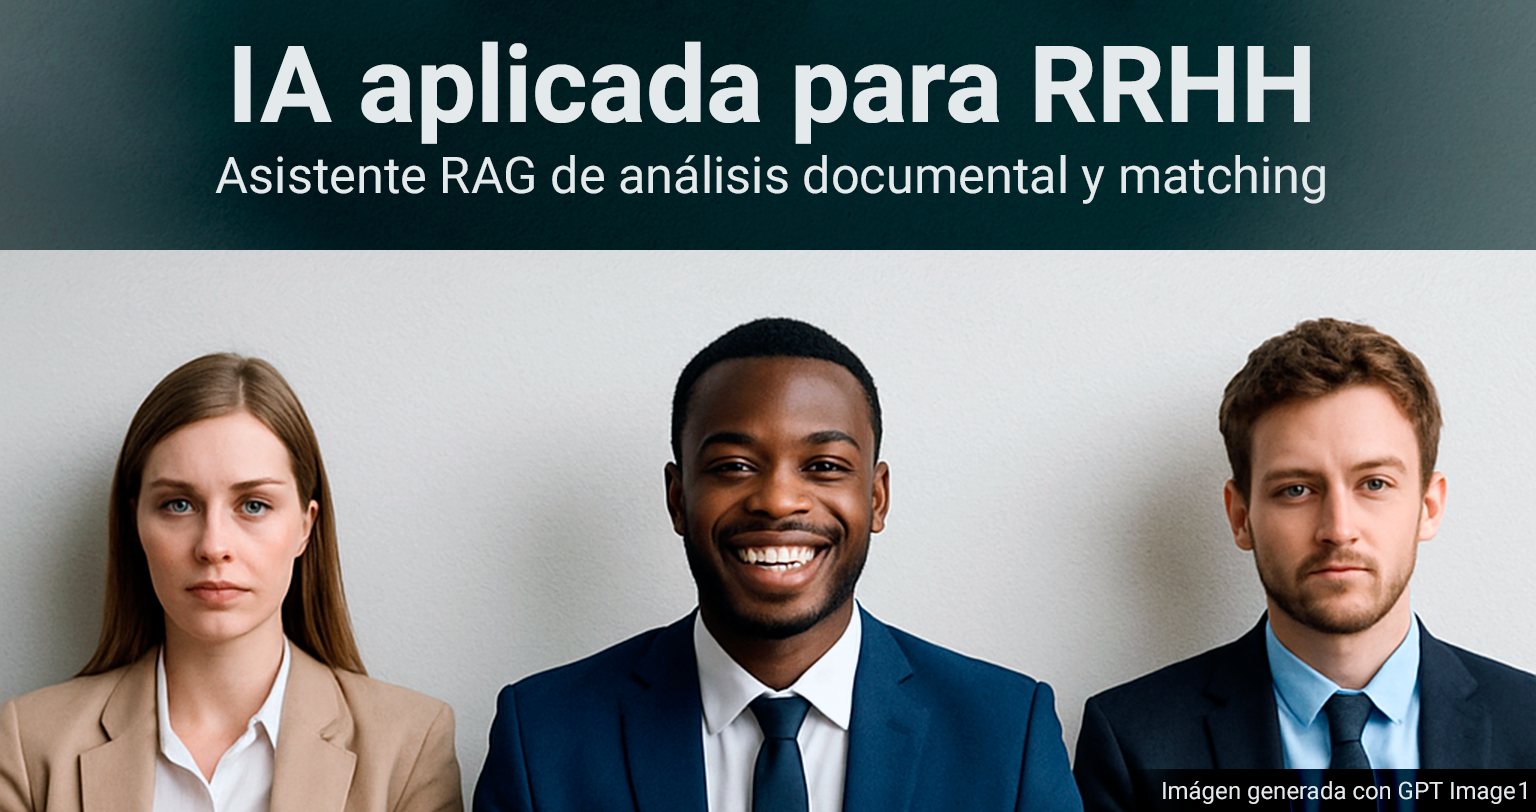

# 0. Introducci√≥n

En los departamentos de Recursos Humanos, gran parte del trabajo gira en torno a revisar documentos: curr√≠culums, ofertas de empleo, pol√≠ticas internas, informes de rendimiento, bases de datos de candidatos... Esta informaci√≥n suele estar repartida en m√∫ltiples formatos y lugares. Por lo que encontrar una respuesta concreta como podr√≠a ser:

*Como saber si un perfil encaja con una oferta o qu√© normas aplican a un puesto espec√≠fico.*

Se convierte en una tarea lenta y repetitiva.

Con la llegada de los modelos de lenguaje e inteligencia artificial, se abre la puerta a automatizar parte de este proceso. En lugar de que una persona tenga que leer y comparar todos los documentos manualmente, podemos construir un sistema inteligente que entienda las preguntas del usuario, busque la informaci√≥n m√°s relevante y genere respuestas claras y √∫tiles basadas en los documentos disponibles.

Este proyecto propone aplicar esta idea a un entorno realista de **RRHH** y selecci√≥n de personal, construyendo un asistente que trabaje con documentos en distintos formatos y ayude a responder consultas habituales del d√≠a a d√≠a:

Desde identificar qu√© candidato encaja mejor en un puesto, hasta consultar normativas internas o analizar perfiles disponibles dentro de la empresa.


# 1. Objetivo y Contexto del Proyecto

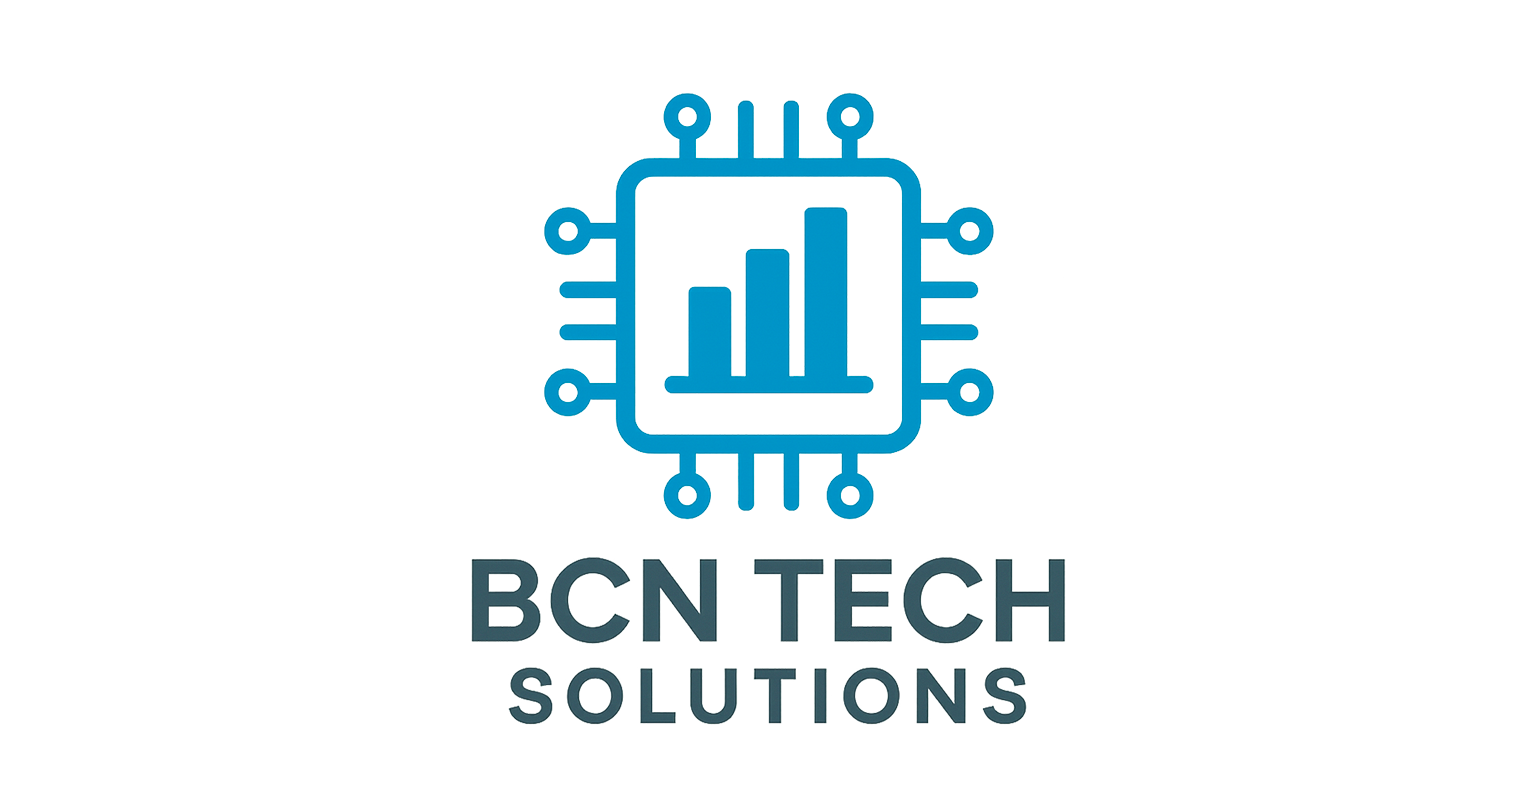

Este proyecto tiene como objetivo desarrollar un sistema inteligente basado en **RAG (Retrieval-Augmented Generation)** que permita consultar, comparar y analizar documentos clave del √°rea de **Recursos Humanos y selecci√≥n de personal**.

Se ha dise√±ado una simulaci√≥n realista basada en la empresa ficticia **BCN Tech Solutions**, una consultora tecnol√≥gica con sede en Barcelona, especializada en anal√≠tica de datos, automatizaci√≥n e IA aplicada.

**BCN Tech Solutions:**

- **Sector**: Consultor√≠a tecnol√≥gica
- **Tama√±o**: 85 empleados
- **√Åreas de negocio**: Data Science, automatizaci√≥n, visualizaci√≥n de datos, RRHH digital
- **Cultura**: Trabajo h√≠brido, desarrollo del talento, documentaci√≥n clara y uso de IA interna

**Objetivo del sistema RAG:**

El sistema busca responder preguntas reales sobre documentos t√≠picos del entorno de RRHH:

- ¬øQu√© perfil encaja mejor con una oferta publicada?
- ¬øQu√© trayectoria ha tenido un empleado que opta a una promoci√≥n?
- ¬øQu√© dice la normativa interna sobre vacaciones o teletrabajo?
- ¬øQui√©n tiene mejor evoluci√≥n en desempe√±o en el equipo de datos?

**Tipos de documentos utilizados:**

El asistente se entrenar√° sobre una base documental que simula los archivos reales de una empresa, en 5 formatos distintos:

| Tipo de Documento            | Formato | Ejemplos                                        |
|-----------------------------|---------|--------------------------------------------------|
| CVs de candidatos externos  | PDF/DOCX | 20 perfiles con experiencia y formaci√≥n diversa  |
| CVs de empleados internos   | PDF/DOCX | 10 perfiles con trayectoria dentro de la empresa |
| Informes de rendimiento     | PDF     | Evaluaciones semestrales y recomendaciones       |
| Pol√≠ticas internas          | DOCX    | Normas sobre vacaciones, teletrabajo, igualdad   |
| Descripciones de puesto     | TXT     | Ofertas activas con requisitos y condiciones     |
| Gu√≠as internas (wiki)       | Markdown| Documentaci√≥n de procesos internos               |

**Enfoque t√©cnico:**

El sistema aplica t√©cnicas de NLP y RAG para:

- Procesar m√∫ltiples formatos con `unstructured`, `PyMuPDF`, `python-docx` y `markdown`

- Generar embeddings con modelos open-source y close-source

- Almacenar vectores en una base de datos sem√°ntica (FAISS)

- Recuperar contexto relevante y generar respuestas con LLMs

Este proyecto simula un caso de uso realista y completo de IA aplicada al an√°lisis documental interno en una empresa de consultor√≠a.

A continuaci√≥n se muestra el **Pipeline** que se seguir√° en el proyecto:

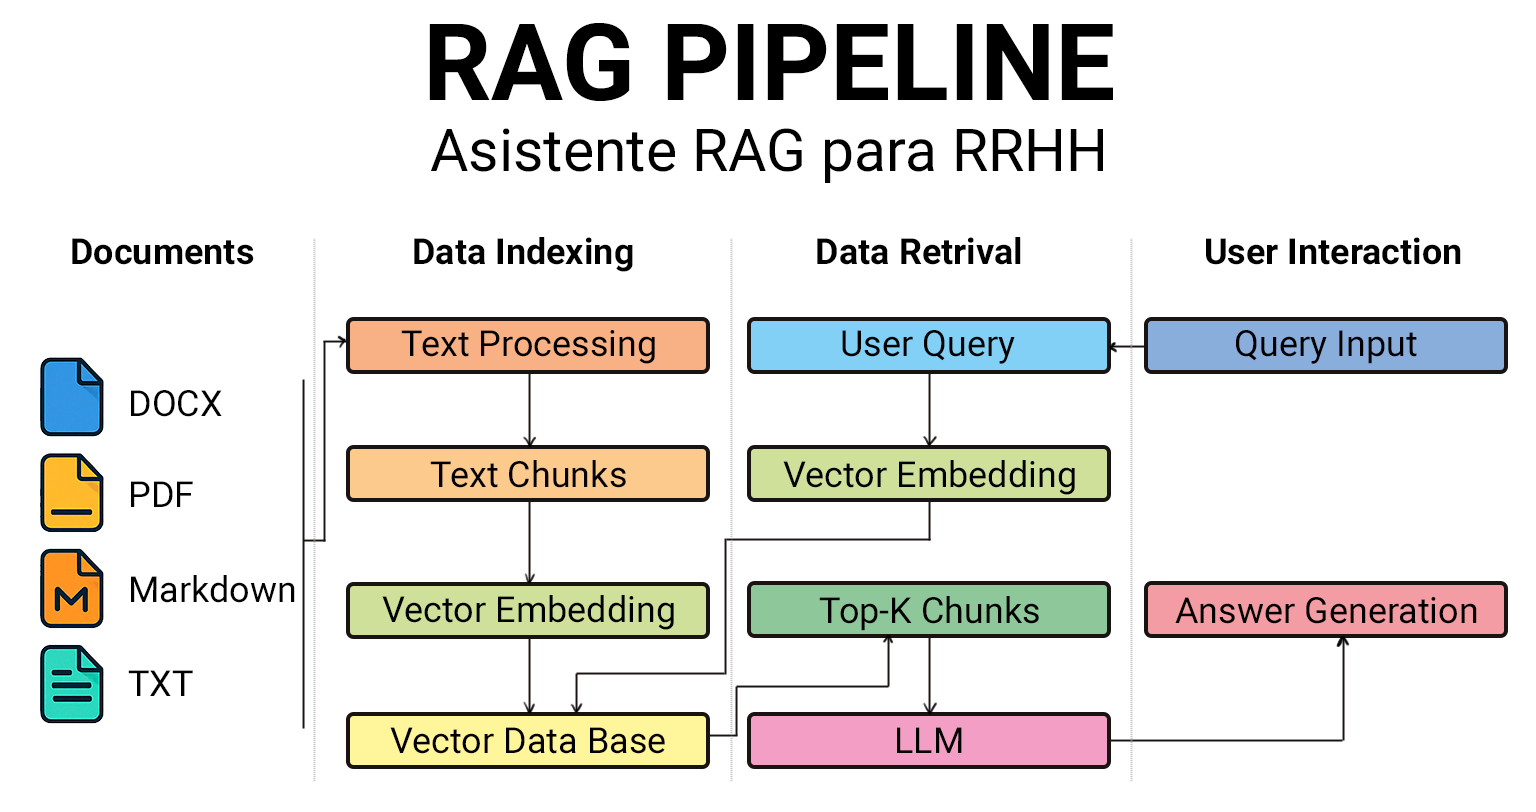

# 2. Ingesta Multiformato

Estructura del dataset simulado o real

Procesamiento de:

üìÑ PDFs (CVs e informes de rendimiento)

üìÉ DOCX (CVs y pol√≠ticas internas)

üìù TXT (descripciones de puestos)

üìë CSV/JSON (bases de datos de candidatos)

üåê Markdown/HTML (formato complementario, si aplica)

Limpieza y normalizaci√≥n del texto

## 2.1. Instalaci√≥n e importaci√≥n de herramientas

In [1]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Instalar dependencias que no est√°n por defecto en Colab
!pip install faiss-cpu PyMuPDF python-docx markdown beautifulsoup4 wordcloud

# Librer√≠as generales
import re
import os
import glob
import pandas as pd
import numpy as np

# Procesamiento de archivos y datos
import time, os, re
from collections import defaultdict
import string

# NLP y embeddings
from sentence_transformers import SentenceTransformer
import faiss
# Embeddings de OPEN AI????

# Manejo de documentos multiformato
import fitz                    # PyMuPDF - PDFs
import docx                    # DOCX
from markdown import markdown  # Markdown
from bs4 import BeautifulSoup  # Convertir markdown a texto limpio

# Utilidades de chunking y limpieza
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
from sklearn.decomposition import PCA


# Modelo LLM (Chat GPT de OpenAI)
!pip install openai --quiet

# API KEY
# Dotenv para proteger la API key
!pip install python-dotenv
from dotenv import load_dotenv

# Ruta de API KEY
# M√°s info: https://pypi.org/project/python-dotenv/
env_path = "/content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/config/.env"

load_dotenv(env_path)
api_key = os.getenv("OPENAI_API_KEY")

if api_key is None:
    raise ValueError("No se ha encontrado la clave API.")

# Configuraci√≥n de OpenAI
from openai import OpenAI
client = OpenAI(api_key=api_key)

# Visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31.4/31.4 MB 35.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.1/24.1 MB 27.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 253.0/253.0 kB 7.6 MB/s eta 0:00:00


## 2.2 Ruta y lectura de archivos

Vamos a preparar la ruta de acceso a todos los documentos que forman parte de la base documental del asistente RAG.

Definiremos las rutas en Google Drive para cada tipo de archivo (CVs de candidatos y empleados, descripciones de puestos, pol√≠ticas internas, informes de rendimiento y gu√≠as en formato Markdown).

Crearemos funciones espec√≠ficas de lectura seg√∫n el formato:

`leer_pdf()` usar√° **PyMuPDF** para extraer texto de los **PDFs**.

`leer_docx()` utilizar√° **python-docx** para recorrer los p√°rrafos de los archivos **Word**.

`leer_txt()` abrir√° ficheros de texto con codificaci√≥n **UTF-8**.

`leer_md()` convertir√° **Markdown** a **HTML** con la librer√≠a **markdown** y lo limpiar√° con **BeautifulSoup** para quedarnos solo con el texto.

Con esto conseguimos un pipeline unificado de lectura que nos permitir√° normalizar el contenido de m√∫ltiples fuentes en un mismo flujo de datos.

In [3]:
#===============================================================================
# Rutas en Drive
#===============================================================================
BASE = '/content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/data/'
PATHS = {
    "cv_ext_pdf":    BASE + 'candidate_resumes/pdf/*.pdf',
    "cv_ext_docx":   BASE + 'candidate_resumes/docx/*.docx',
    "cv_int_pdf":    BASE + 'employee_resumes/pdf/*.pdf',
    "cv_int_docx":   BASE + 'employee_resumes/docx/*.docx',
    "jobs_txt":      BASE + 'job_postings/*.txt',
    "policies_docx": BASE + 'internal_policies/*.docx',
    "reports_pdf":   BASE + 'performance_reviews/*.pdf',
    "guides_md":     BASE + 'internal_documentation/*.md',
}

In [4]:
#===============================================================================
# Funciones de lecutra
#===============================================================================
def leer_pdf(path):
    # Abrimos archivos PDF usando PyMuPDF (fitz)
    doc = fitz.open(path)
    # Extracci√≥n del texto y concatenaci√≥n
    texto = ''.join(page.get_text() for page in doc)
    return texto

def leer_docx(path):
    # Abrimos archivos .docx usando python-docx
    d = docx.Document(path)
    # Devuelve el texto separado por saltos de l√≠nea
    return '\n'.join(p.text for p in d.paragraphs)

def leer_txt(path, encoding='utf-8'):
    # Abrimos archivos txt con el encoding indicado (por defecto UTF-8)
    with open(path, 'r', encoding=encoding, errors='ignore') as f:
        return f.read()

def leer_md(path):
    # Leemos archivos Markdown
    raw = leer_txt(path)
    # Conviertimos el texto Markdown a HTML
    html = markdown(raw)
    # Usamos BeautifulSoup para limpiar el HTML
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text(separator='\n')

## 2.3 Carga de archivos

En este paso vamos a **leer y consolidar todos los documentos** que forman parte del corpus de Recursos Humanos de *BCN Tech Solutions*.  

- Vamos a empezar definiendo una funci√≥n auxiliar `cargar_lista()` la cual:  
  - Buscar√° todos los archivos que coincidan con un patr√≥n de ruta.  
  - Aplicar√° la funci√≥n de lectura correspondiente seg√∫n el formato.  
  - Devolver√° una lista de diccionarios con la ruta del archivo y su texto.  

- A continuaci√≥n, cargaremos cada tipo de documento asign√°ndole un **identificador de tipo (`doc_type`)**:  
  - **CVs externos** (`cv_externo`)  
  - **CVs internos** (`cv_interno`)  
  - **Descripciones de puestos** (`job_desc`)  
  - **Pol√≠ticas internas** (`policy`)  
  - **Informes de rendimiento** (`report`)  
  - **Gu√≠as internas (Markdown)** (`guide_md`)  

- Finalmente, unificaremos toda esta informaci√≥n en un **DataFrame de Pandas**, lo que nos permitir√°:  
  - Tener una vista general de todos los documentos.  
  - Ver r√°pidamente el n√∫mero total de archivos cargados.  
  - Acceder al texto asociado a cada documento para posteriores fases de limpieza, chunking y embeddings.  



In [5]:
#===============================================================================
# Funci√≥n de carga
#===============================================================================
def cargar_lista(pattern, reader_fn):
    # Buscamos todos los archivos que coincidan con el patr√≥n (ej: "*.pdf")
    files = glob.glob(pattern)
    # Para cada archivo guardamos su ruta (path), leeemos su contenido y devuelve una lista de diccionarios
    return [{"path": p, "text": reader_fn(p)} for p in files]

In [6]:
#===============================================================================
# Carga de archvios en df
#===============================================================================

# Lista vacia
corpus = []

# CVs externos e internos
corpus += [{"doc_type":"cv_externo", **d} for d in cargar_lista(PATHS["cv_ext_pdf"], leer_pdf)]
corpus += [{"doc_type":"cv_externo", **d} for d in cargar_lista(PATHS["cv_ext_docx"], leer_docx)]
corpus += [{"doc_type":"cv_interno", **d} for d in cargar_lista(PATHS["cv_int_pdf"], leer_pdf)]
corpus += [{"doc_type":"cv_interno", **d} for d in cargar_lista(PATHS["cv_int_docx"], leer_docx)]

# Vacantes, pol√≠ticas, informes y gu√≠as
corpus += [{"doc_type":"job_desc", **d}     for d in cargar_lista(PATHS["jobs_txt"], leer_txt)]
corpus += [{"doc_type":"policy", **d}       for d in cargar_lista(PATHS["policies_docx"], leer_docx)]
corpus += [{"doc_type":"report", **d}       for d in cargar_lista(PATHS["reports_pdf"], leer_pdf)]
corpus += [{"doc_type":"guide_md", **d}     for d in cargar_lista(PATHS["guides_md"], leer_md)]

# Conversi√≥n de lista de diccionarios a DataFrame de Pandas
df = pd.DataFrame(corpus)
print("Documentos cargados:", len(df))
df.head(5)

Documentos cargados: 49


doc_type                                               path  \
0  cv_externo  /content/drive/MyDrive/Colab Notebooks/BS - DS...   
1  cv_externo  /content/drive/MyDrive/Colab Notebooks/BS - DS...   
2  cv_externo  /content/drive/MyDrive/Colab Notebooks/BS - DS...   
3  cv_externo  /content/drive/MyDrive/Colab Notebooks/BS - DS...   
4  cv_externo  /content/drive/MyDrive/Colab Notebooks/BS - DS...   

                                                text  
0  Cebri√°n de M√∫gica\nPuesto: Junior Data Analyst...  
1  H√©ctor Mariano Bellido Losa\nPuesto: Data Engi...  
2  Eligia Alemany Cases\nPuesto: Data Analyst\nAn...  
3  Dulce Tolosa Vald√©s\nPuesto: Data Analyst\nAnt...  
4  Vinicio Milla Agust√≠n\nPuesto: BI Consultant\n...

En este caso hemos cargado un total de 49 documentos, y podemos observar como nuestro Data Frame se ha creado correctamente, manteniendo la informaci√≥n del tipo de documento, su ruta o ubicaci√≥n y el texto del mismo.

# 3. Limpieza, Chunking y Embeddings

## 3.1 Limpieza de texto

Antes de procesar los documentos para **chunking** y **embeddings**, vamos a normalizar su contenido. As√≠, podremos garantizar que todos los textos tengan un formato coherente y legible, evitando ruido que pueda afectar al modelo.  

- Definiremos la funci√≥n `limpiar_texto_preservando_parrafos()`, la cual:  
   - Normalizar√° saltos de l√≠nea (`\r`, `\n`).  
   - Sustituir√° caracteres nulos (`\x00`) y eliminar√° espacios innecesarios.  
   - Colapsar√° m√∫ltiples espacios o tabs dentro de cada l√≠nea.  
   - Quitar√° espacios en blanco al inicio y final de cada l√≠nea.  
   - Compactar√° saltos de l√≠nea excesivos, preservando **doble salto como marca de p√°rrafo**.  
   - Eliminar√° l√≠neas vac√≠as al inicio y al final del texto.  

- Aplicaremos esta limpieza a la columna `text` de nuestro DataFrame `df`, de modo que **todos los documentos queden listos para la fase de segmentaci√≥n en chunks**.  


In [7]:
#===============================================================================
# Funci√≥n de limpieza de texto por par√°metro
#===============================================================================
def limpiar_texto_preservando_parrafos(s):
    if not isinstance(s, str):
        return ""
    # Normalizamos el fin de l√≠nea
    s = s.replace('\r\n', '\n').replace('\r', '\n')
    s = s.replace('\x00', ' ').strip()

    # 1) Colapsamos espacios/tabs dentro de cada l√≠nea
    s = re.sub(r'[ \t]+', ' ', s)

    # 2) Quitamos espacios al inicio/fin de cada l√≠nea
    s = '\n'.join(line.strip() for line in s.split('\n'))

    # 3) Compactamos m√∫ltiples saltos de l√≠nea en DOBLE salto (marca de p√°rrafo)
    s = re.sub(r'\n{3,}', '\n\n', s)

    # 4) Eliminamos l√≠neas vac√≠as al principio y final
    s = s.strip('\n')

    return s

In [8]:
# Aplicar limpieza
df["text"] = df["text"].map(limpiar_texto_preservando_parrafos)

## 3.2 Chunking

Para mejorar la recuperaci√≥n de contexto en nuestro sistema RAG, vamos a implementar y comparar **diferentes estrategias de segmentaci√≥n de documentos (chunking)**.  
El *chunking* es necesario porque los documentos pueden ser demasiado largos para generar embeddings completos, y dividirlos de forma adecuada permite obtener fragmentos m√°s manejables y sem√°nticamente coherentes.

**1. Baseline por caracteres** (`chars`)
- M√©todo inicial.
- Divide el texto en ventanas de tama√±o fijo (`max_chars = 240`) con solapamiento (`overlap = 40`).
- Ventaja: asegura cortes uniformes, √∫til para cualquier tipo de documento.
- Limitaci√≥n: los cortes pueden romper frases o secciones importantes, lo que reduce la coherencia sem√°ntica.

**2. Chunking por p√°rrafos** (`paragraphs`)
- Inspirado en la estructura natural de los textos.
- Respeta saltos de l√≠nea, listas y bloques de p√°rrafos.
- Se espera que produzca chunks m√°s ‚Äúnaturales‚Äù que `chars`.

**3. Chunking adaptativo por tipo de documento** (`doctype`)
- Aplica reglas diferentes seg√∫n el `doc_type` del documento:
  - **CVs:** se dividen por frases, resaltando secciones como *Experiencia*, *Educaci√≥n*, *Habilidades*.
  - **Ofertas de empleo (job_desc):** se dividen por p√°rrafos, con marcadores en ep√≠grafes como *Requisitos* o *Responsabilidades*.
  - **Pol√≠ticas internas:** se segmentan en bloques m√°s largos, preservando secciones normativas.
  - **Informes de rendimiento:** se trocean por frases y puntuaciones de evaluaci√≥n.
  - **Gu√≠as internas (wiki):** se segmentan por p√°rrafos para mantener la l√≥gica de documentaci√≥n.
- Este enfoque genera chunks **diferentes y adaptados**



In [9]:
# ==============================================================================
# M√©todos de chunking
# - chunk_text ("chars")
# - chunk_by_paragraph ("paragraphs")
# - chunk_by_doctype ("doctype")
# ==============================================================================

#===============================================================================
# chunk_text (m√©todo "chars")
#===============================================================================
def chunk_text(text, max_chars=900, overlap=150):

    # Lista de fragmentos (chunks)
    chunks = []

    # √çndice inicial
    start = 0
    # Longitud total del texto
    n = len(text)

    # Mientras no hayamos llegado al final del texto
    while start < n:
        end = min(start + max_chars, n)   # Ventana de hasta 900 chars
        chunk = text[start:end]           # Recorte del texto
        chunks.append(chunk)              # A√±adimos el recorte a la lista
        if end == n: break                # Si ya llegamos al final, paramos
        start = max(0, end - overlap)     # Retrocede 150 chars para solapar
    return chunks

#===============================================================================
# chunk_by_paragraph (m√©todo "paragraphs")
#===============================================================================

#==========================================
# 1) Arreglo de saltos de l√≠nea duros y guiones de corte
#==========================================

def _fix_hard_breaks(text):
    # Si text no es str, devolvemos cadena vac√≠a por seguridad
    if not isinstance(text, str):
        return ""
    # Normalizamos saltos de l√≠nea a \n
    t = text.replace('\r\n', '\n').replace('\r', '\n')
    # Reparamos guiones de corte de l√≠nea (ej: "con-\ntexto" = "contexto")
    t = re.sub(r'-\n(\w)', r'\1', t)
    # Funci√≥n para unir l√≠neas con un espacio cuando no hay un final de oraci√≥n
    def joiner(match):
        a, b = match.group(1), match.group(2)
        return a + ' ' + b
    # Buscamos saltos de l√≠nea que no siguen a signos de fin de frase . ! ? :
    # Aseguramos que no sea un doble salto de l√≠nea (?!\n)
    # Y que la siguiente l√≠nea no empiece por -, * o ‚Ä¢ para no romper listas
    # Reemplazamos ese salto por un espacio
    t = re.sub(r'([^\.\!\?\:])\n(?!\n)([^\-\*\‚Ä¢])', joiner, t)
    return t

#==========================================
# 2) Dividimos el texto en parrafos
#==========================================
def _split_paragraphs(text):
    # Dividimos por bloques usando saltos de l√≠nea en blanco (p√°rrafos)
    blocks = re.split(r'\n\s*\n+', text.strip())
    # Lista para el output
    out = []
    # Bucle para cada bloque/p√°rrafo
    for blk in blocks:
        # Dividimos el bloque en l√≠neas, quitamos espacios y descartamos l√≠neas vac√≠as
        lines = [l.strip() for l in blk.split('\n') if l.strip()]
        # Condici√≥n para detectar listas: "all": todas las l√≠neas son √≠tems "any": al menos una lo es
        if all(re.match(r'^(\-|\*|\‚Ä¢|\d+[\.\)]|\‚Ä¢)\s+', ln) or len(ln) < 140 for ln in lines) and \
           any(re.match(r'^(\-|\*|\‚Ä¢|\d+[\.\)]|\‚Ä¢)\s+', ln) for ln in lines):
            # Lista acumuladora
            current = []
            # Bucle de lineas
            for ln in lines:
                # Si la l√≠nea empieza como √≠tem, en caso de que exista texto acumulado (no √≠tem), lo guardamos como un p√°rrafo antes del √≠tem
                if re.match(r'^(\-|\*|\‚Ä¢|\d+[\.\)]|\‚Ä¢)\s+', ln):
                    if current:
                        out.append(' '.join(current).strip())
                        current = []
                    # A√±adimos el √≠tem como una unidad independiente
                    out.append(ln)
                # Si no es √≠tem, acumula en current
                else:
                    current.append(ln)
            # A√±adimos el resto acumulado al final (si existe)
            if current:
                out.append(' '.join(current).strip())
        # Si el bloque no es lista, unimos las l√≠neas en un √∫nico p√°rrafo
        else:
            out.append(' '.join(lines).strip())
    return [p for p in out if p]

#==========================================
# 3) Creamos los chunks
#==========================================
def chunk_by_paragraph(text, max_chars=900, overlap_chars=150):
    # Seguridad: si no es texto o est√° vac√≠o, retornamos la lista vac√≠a
    if not isinstance(text, str) or not text.strip():
        return []
    # Normalizamos saltos de l√≠nea y guiones
    t = _fix_hard_breaks(text)
    # Dividimos en p√°rrafos/√≠tems
    paras = _split_paragraphs(t)
    # chunks: resultado - buf: buffer donde acumulamos p√°rrafos hasta llegar a max_chars
    chunks, buf = [], ""
    # Bucle de cada p√°rrafo
    for p in paras:
        # Si el p√°rrafo es demasiado largo: lo troceamos directamente en ventanas
        if len(p) > max_chars:
            if buf:
                chunks.append(buf.strip()); buf = ""
            start, n = 0, len(p)
            while start < n:
                end = min(start + max_chars, n)
                slice_ = p[start:end]
                chunks.append(slice_)
                if end == n: break
                start = max(0, end - overlap_chars)
        # Si es m√°s corto: intentamos agruparlo en el buffer con otros p√°rrafos
        else:
            if len(buf) + (1 if buf else 0) + len(p) <= max_chars:
                buf = (buf + " " + p) if buf else p
            else:
                if buf:
                    chunks.append(buf.strip())
                    tail = buf[-overlap_chars:] if len(buf) > overlap_chars else buf
                else:
                    tail = ""
                buf = (tail + " " + p).strip() if tail else p
    # Si el buffer se llena: lo volcamos como chunk y empezamos uno nuevo, manteniendo solape con tail
    if buf:
        chunks.append(buf.strip())
    return chunks

# ============================================================================
# chunk_by_doctype (m√©todo "doctype")
# ============================================================================

#==========================================
# 1) Funciones de segmentaci√≥n y arreglos de texto
#==========================================

# Split sentences (troceamos textos en frases)
def split_sentences_es(text):
    # Seguridad: si no es texto o est√° vac√≠o, retornamos la lista vac√≠a
    if not isinstance(text, str) or not text.strip():
        return []
    # Si es texto: Lo dividimos con re.split limpiando espacios
    parts = re.split(r'(?<=[\.\!\?\;\:])\s+(?=(?:[-\*\‚Ä¢]|\d+[\.\)]|[A-Z√Å√â√ç√ì√ö√ë]))', text.strip())
    return [p.strip() for p in parts if p.strip()]

# Inject paragraph hints (Inserci√≥n de saltos de l√≠nea dobles y conversi√≥n de bullets en l√≠neas separadas)
def _inject_paragraph_hints(text, markers):
    """Inserta doble salto antes de cabeceras para ayudar a paragraphs."""
    # Seguridad: Si no hay marcadores a buscar, devuelve sin tocar
    if not markers:
        return text
    # Variable de texto
    t = text
    # Bucle para cada marcador donde evitamos que caracteres especiales, buscamos espacios, y dos puntos
    for m in markers:
        t = re.sub(fr'\s({re.escape(m)}\s*:?)', r'\n\n\1', t, flags=re.IGNORECASE)
    # Convertimos bullets lineales en l√≠neas separadas
    t = re.sub(r'\s-\s', r'\n- ', t)
    t = re.sub(r'\s‚Ä¢\s', r'\n‚Ä¢ ', t)
    return t

# Pack Units (Empaquetamos unidades en chunks)
def _pack_units(units, max_chars=900, overlap=150):
    """Empaqueta 'units' respetando tama√±o y solape."""
    # Lista de chunks final y buffer de acumulaci√≥n
    chunks, buf = [], ""
    # Bucle de unidades
    for u in units:
        # Caso 1: La unidad es m√°s larga que el m√°ximo permitido
        if len(u) > max_chars:
            # Si el buffer tiene texto acumulado, lo mandamos a chunks y vaciamos
            if buf:
                chunks.append(buf.strip()); buf = ""
            start, n = 0, len(u)
            # Preparamos √≠ndices para trocear la unidad larga
            while start < n:
                end = min(start + max_chars, n)
                chunks.append(u[start:end])
                # Si no llega al final, retrocede el inicio overlap caracteres para generar solape entre subcortes
                if end == n: break
                start = max(0, end - overlap)
        # Caso 2: La unidad cabe en un chunk
        else:
            # Comprobamos si cabe a√±adir "u" al buffer actual sin pasarse
            if len(buf) + (1 if buf else 0) + len(u) <= max_chars:
                # Si cabe, concatenamos al buffer (con espacio si ya hab√≠a contenido)
                buf = (buf + " " + u) if buf else u
            # En caso de que no quepa:
            else:
                # Si el buffer ten√≠a contenido, lo cierra haciendo un append a chunks
                if buf:
                    chunks.append(buf.strip())
                    tail = buf[-overlap:] if len(buf) > overlap else buf
                # Calcula tail: la cola del buffer con longitud overlap. Esta cola se usar√° como solape con el siguiente chunk
                else:
                    tail = ""
                buf = (tail + " " + u).strip() if tail else u
    # Al final del bucle, si queda algo en el buffer, lo a√±adimos como √∫ltimo chunk
    if buf:
        chunks.append(buf.strip())
    return chunks

#==========================================
# 2) Reglas por tipo de documento
#==========================================
DOCTYPE_RULES = {
    # CVs: muchas l√≠neas cortas, lo haremos por frases compactas
    "cv_externo": {"strategy": "sentences",   "max": 220, "ov": 30,
                   "markers": ["Resumen profesional","Experiencia","Educaci√≥n","Habilidades","Idiomas","Proyectos"]},
    "cv_interno": {"strategy": "sentences",   "max": 220, "ov": 30,
                   "markers": ["Resumen profesional","Experiencia","Educaci√≥n","Habilidades","Idiomas","Proyectos"]},

    # Ofertas: ep√≠grafes claros, usaremos paragraphs con l√≠mites medios
    "job_desc":   {"strategy": "paragraphs",  "max": 260, "ov": 40,
                   "markers": ["Requisitos","Responsabilidades","Funciones","Beneficios","Condiciones","Descripci√≥n","Perfil"]},

    # Pol√≠ticas internas: tenemos secciones, usaremos paragraphs algo m√°s grandes
    "policy":     {"strategy": "paragraphs",  "max": 300, "ov": 60,
                   "markers": ["Objeto","√Åmbito","Definiciones","Procedimiento","Vacaciones","Permisos","Teletrabajo","Igualdad"]},

    # Informes de rendimiento: frases/√≠tems puntuados, usaremos sentences
    "report":     {"strategy": "sentences",   "max": 240, "ov": 40,
                   "markers": ["Evaluaci√≥n","Historial","Conclusiones","Recomendaciones","Objetivos"]},

    # Gu√≠as: suelen ser markdown, usaremos paragraphs
    "guide_md":   {"strategy": "paragraphs",  "max": 280, "ov": 50,
                   "markers": ["Introducci√≥n","Procedimiento","Pasos","Notas","Ejemplo","Resumen"]},

    # Gen√©rico en caso de que no se detecte, usaremos chars
    "_default":   {"strategy": "chars",       "max": 240, "ov": 40, "markers": []},
}

#==========================================
# 3) Creamos los chunks
#==========================================
def chunk_by_doctype(text, doc_type="", max_chars=900, overlap=150):
    """
    Aplicamos reglas por doc_type para seleccionar estrategia y tama√±os.
    - Si no hay regla: usamos _default que es el gen√©rico (chars).
    - max_chars/overlap act√∫an como valores por defecto globales,
      pero se sobrescriben por los de la regla cuando exista.
    """
    if not isinstance(text, str) or not text.strip():
        return []

    # Selecci√≥n de las reglas
    rule = DOCTYPE_RULES.get(doc_type, DOCTYPE_RULES["_default"])
    strategy   = rule.get("strategy", "chars")
    M          = rule.get("max", max_chars)
    OV         = rule.get("ov", overlap)
    markers    = rule.get("markers", [])

    # Normalizaci√≥n ligera y hints
    t = _fix_hard_breaks(text)
    t = _inject_paragraph_hints(t, markers)

    if strategy == "chars":
        return chunk_text(t, max_chars=M, overlap=OV)

    elif strategy == "paragraphs":
        units = _split_paragraphs(t)
        if len(units) <= 1:
            # Usamos frases si no detectamos p√°rrafos √∫tiles
            units = split_sentences_es(t)
        return _pack_units(units, max_chars=M, overlap=OV)

    elif strategy == "sentences":
        units = split_sentences_es(t)
        if not units:
            # Usamos el generico (chars), si no hay frases detectables
            return chunk_text(t, max_chars=M, overlap=OV)
        return _pack_units(units, max_chars=M, overlap=OV)

    # Retorno final
    return chunk_text(t, max_chars=M, overlap=OV)

#===============================================================================
# Registro de chunkers
#===============================================================================
# Diccionario de ‚Äúm√©todos de chunking‚Äù
CHUNKERS = {
    "chars": lambda text, **kw: chunk_text(
        text,
        **{k: kw[k] for k in ("max_chars", "overlap") if k in kw}
    ),
    "paragraphs": lambda text, **kw: chunk_by_paragraph(
        text,
        max_chars=kw.get("max_chars", 900),
        overlap_chars=kw.get("overlap", 150)
    ),
    "doctype": lambda text, **kw: chunk_by_doctype(
        text,
        doc_type=kw.get("doc_type", ""),
        max_chars=kw.get("max_chars", 900),
        overlap=kw.get("overlap", 150)
    ),
}
# ============================================================================
# Helper para construir DataFrames de chunks con el m√©todo elegido
# ============================================================================
def build_chunks_df(df, method="chars", max_chars=900, overlap=150):
    """
    Crea un DataFrame de chunks usando el m√©todo seleccionado en CHUNKERS.
    - method: "chars", "paragraphs" y "doctype".
    - max_chars, overlap: pasan al chunker correspondiente
    """
    if method not in CHUNKERS:
        raise ValueError(f"M√©todo desconocido: {method}. Usa uno de {list(CHUNKERS.keys())}")
    if "text" not in df.columns:
        raise ValueError("El DataFrame de documentos no tiene la columna 'text'.")

    rows = []
    chunk_fn = CHUNKERS[method]

    for i, row in df.iterrows():
        txt = row["text"] if isinstance(row.get("text", ""), str) else ""
        chunks = chunk_fn(
            txt,
            max_chars=max_chars,
            overlap=overlap,
            doc_type=row.get("doc_type", "")
        )
        for j, ch in enumerate(chunks):
            rows.append({
                "source_id": i,
                "doc_type": row.get("doc_type", ""),
                "path": row.get("path", ""),
                "chunk_id": j,
                "chunk_text": ch,
                "chunk_method": method
            })

    return pd.DataFrame(rows)

# ============================================================================
# Normalizamos las columnas comunes y a√±adimos un id por chunk
# ============================================================================
def add_chunk_uid(ddf, prefix):
    ddf = ddf.copy()
    ddf["chunk_uid"] = prefix + "_" + ddf["source_id"].astype(str) + "_" + ddf["chunk_id"].astype(str)
    return ddf

In [10]:
# ============================================================================
# Construir los DataFrames de chunks
# ============================================================================
# Construir los dos DataFrames de chunks
MAX = 240
OV  = 40

chunks_df_chars = build_chunks_df(df, method="chars",      max_chars=MAX, overlap=OV)
chunks_df_par   = build_chunks_df(df, method="paragraphs", max_chars=MAX, overlap=OV)
chunks_df_dtype = build_chunks_df(df, method="doctype",    max_chars=MAX, overlap=OV)

print("Chars:", len(chunks_df_chars), " | Paragraphs:", len(chunks_df_par), " | Doctype:", len(chunks_df_dtype))

# UIDs
chunks_df_chars = add_chunk_uid(chunks_df_chars, "C")
chunks_df_par   = add_chunk_uid(chunks_df_par,   "P")
chunks_df_dtype = add_chunk_uid(chunks_df_dtype, "D")

Chars: 158  | Paragraphs: 158  | Doctype: 179


**Resultados:**

Tras comparar los resultados de los tres m√©todos de chunking (Chars, Paragraphs y Doctype), observamos lo siguiente:  

- **Chars**: genera 158 chunks totales. Act√∫a como base, cortando por n√∫mero de caracteres.  
- **Paragraphs**: tambi√©n genera 158 chunks. Debido a que los textos de nuestro corpus tienen pocos saltos de p√°rrafo, los resultados son pr√°cticamente id√©nticos a **Chars**, con solo ligeras diferencias en algunos `doc_type`.  
- **Doctype**: genera 179 chunks, aplicando reglas sem√°nticas espec√≠ficas seg√∫n el tipo de documento. Este m√©todo s√≠ introduce cortes diferenciados y m√°s alineados con la estructura real de los CVs, pol√≠ticas e informes.  

Por esto, vamos a tomar las siguientes decisiones:  
- **Conservamos Chars** como base simple.  
- **Conservamos Doctype** como chunking principal, ya que ofrece mayor riqueza sem√°ntica.  
- **Descartamos Paragraphs** para evitar duplicidad, dado que no aporta valor a√±adido al dataset.

As√≠ pues, de ahora en adelante trabajaremos √∫nicamente con dos m√©todos representativos:  
1. *Chars*: Baseline mec√°nico.  
2. *Doctype*: Segmentaci√≥n optimizada por tipo de documento.  


## 3.3 Embeddings

En este paso transformaremos los **chunks de texto** en **vectores de embeddings** utilizando cuatro modelos distintos, combinando modelos *open-source* y modelos de **OpenAI**:

- **`all-MiniLM-L6-v2` (384 dimensiones)**: Modelo ligero y eficiente de *Sentence Transformers*.
- **`all-mpnet-base-v2` (768 dimensiones)**: Modelo m√°s robusto y preciso, con mayor capacidad sem√°ntica.
- **`text-embedding-3-small` (1536 dimensiones)**: Modelo de OpenAI optimizado para coste y rendimiento equilibrado.
- **`text-embedding-3-large` (3072 dimensiones)**: Modelo de OpenAI de m√°xima calidad, con mayor profundidad sem√°ntica.

Para ello vamos a hacer lo siguiente:  
1. **Cargar los modelos** de embeddings (dos locales y dos de OpenAI).  
2. **Generar los embeddings** para los dos m√©todos de chunking:  
   - `chunks_df_chars`: Agrupaci√≥n por n√∫mero de caracteres (baseline).  
   - `chunks_df_dtype`: Segmentaci√≥n adaptada al tipo de documento (chunking sem√°ntico).  
3. **Normalizar todos los embeddings** (L2) para optimizar el c√°lculo de similitud coseno.
4. **Adjuntar los embeddings** a cada DataFrame en nuevas columnas:  
   - `emb_384_minilm`, `emb_768_mpnet`, `emb_1536_oai_small`, `emb_3072_oai_large`.  
5. **Guardar los embeddings en formato `.npz`** junto con `chunk_uid` y `doc_type`, lo que permitir√° reutilizarlos sin necesidad de regenerarlos.  
6. **Comprobar los resultados** mostrando el n√∫mero de chunks, la dimensi√≥n final y un resumen de la distribuci√≥n por tipo de documento.  

De este modo podremos comparar el rendimiento entre **modelos locales (SBERT)** y **modelos de OpenAI**, evaluando el equilibrio entre coste, precisi√≥n y coherencia sem√°ntica en las b√∫squedas del sistema RAG.  



In [11]:
#===============================================================================
# Generaci√≥n y comparaci√≥n de embeddings (MiniLM 384D vs MPNet 768D vs OpenAI)
#===============================================================================

#-----------------------------
# Funciones de apoyo
#-----------------------------

# Cargador de modelos
def get_embedder(model_name: str) -> SentenceTransformer:
    print(f"Cargando modelo local: {model_name}")
    return SentenceTransformer(model_name)

# Funci√≥n principal para generar embedding
def generar_embeddings(chunks_df, embedder, text_col="chunk_text",
                       batch_size=64, show_progress=True, normalize=False):
    """Devuelve un np.ndarray con los embeddings en el mismo orden que chunks_df."""
    # Extraemos la columna de texto, fuerzando a str (por si hay None/n√∫meros) y conviertimos a lista
    textos = chunks_df[text_col].astype(str).tolist()
    # Llamada a encode del modelo para obtener los vectores:
    X = embedder.encode(
        textos,
        batch_size=batch_size,
        show_progress_bar=show_progress,
        convert_to_numpy=True
    )
    # Si normalize = True
    if normalize:
        # Normalizaci√≥n L2 (Componentes acotados en [-1, 1], ayuda con la similitud coseno)
        norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12 # + 1e-12: evita divisiones por cero.
        # Dividimos cada vector por su norma: norma = 1.
        X = X / norms
    return X

# Funci√≥n para a√±adir los embeddings al DataFrame como una nueva columna:
def adjuntar_embeddings(df, X: np.ndarray, col_name: str):
    """Adjunta los embeddings como una columna (lista de np.ndarray por fila)."""
    df[col_name] = list(X)
    return df

# Funci√≥n para guardar uno o varios arrays en un .npz comprimido:
def guardar_npz(salida_path: str, **arrays):
    """Guarda varios arrays en un .npz (clave=nombre)."""
    os.makedirs(os.path.dirname(salida_path), exist_ok=True)
    np.savez_compressed(salida_path, **arrays)
    print(f"Guardado: {salida_path} (keys: {list(arrays.keys())})")

# Funci√≥n r√°pida para imprimir un resumen:
def resumen(df, nombre, cols=["chunk_method","doc_type"]):
    """Peque√±o resumen √∫til tras embeddizar."""
    dims = None
    for c in df.columns[::-1]:
        if c.startswith("emb_") and len(df) > 0 and isinstance(df[c].iloc[0], np.ndarray):
            dims = df[c].iloc[0].shape[0]
            break
    print(f"[{nombre}] n_chunks={len(df)} | √∫ltima_dim={dims} | por doc_type:")
    print(df.groupby(cols).size().rename("n").reset_index().head(10))

#-----------------------------
# Configuraci√≥n
#-----------------------------
MODEL_BASELINE = "sentence-transformers/all-MiniLM-L6-v2"   # 384D
MODEL_STRONG   = "sentence-transformers/all-mpnet-base-v2"  # 768D
OPENAI_SMALL   = "text-embedding-3-small"                   # 1536D
OPENAI_LARGE   = "text-embedding-3-large"                   # 3072D

NORMALIZE = True   # L2 √∫til para similitud coseno
BATCH     = 64     # Mejora el rendimiento si la GPU/CPU y RAM/VRAM lo permiten

# Ruta donde guardar los embeddings
EMB_DIR = "/content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/outputs/embeddings"

#-----------------------------
# Carga de modelos locales
#-----------------------------
embedder_minilm = get_embedder(MODEL_BASELINE)
embedder_mpnet  = get_embedder(MODEL_STRONG)

#-----------------------------
# Cliente OpenAI
#-----------------------------
client = OpenAI(api_key=api_key)

def oai_embed_texts(texts, model=OPENAI_SMALL, batch_size=256, normalize=True):
    """Genera embeddings con OpenAI en lotes."""
    # Lista acumuladora para guardar los arrays de cada lote
    out = []
    # Recorremos texts en saltos de batch_size (0, 256, 512, ‚Ä¶). As√≠ evitamos peticiones gigantes.
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        resp = client.embeddings.create(model=model, input=batch)
        vecs = [np.array(d.embedding, dtype=np.float32) for d in resp.data]
        out.append(np.vstack(vecs))
    X = np.vstack(out)
    # Si normalize = True
    if normalize:
        # Normalizaci√≥n L2 (Componentes acotados en [-1, 1], ayuda con la similitud coseno)
        norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
        # Dividimos cada vector por su norma: norma = 1.
        X = X / norms
    return X

#===============================================================================
# 1) CHARS
#===============================================================================
X_chars_384 = generar_embeddings(chunks_df_chars, embedder_minilm, batch_size=BATCH, normalize=NORMALIZE)
X_chars_768 = generar_embeddings(chunks_df_chars, embedder_mpnet,  batch_size=BATCH, normalize=NORMALIZE)
X_chars_1536 = oai_embed_texts(chunks_df_chars["chunk_text"].tolist(), model=OPENAI_SMALL, normalize=NORMALIZE)
X_chars_3072 = oai_embed_texts(chunks_df_chars["chunk_text"].tolist(), model=OPENAI_LARGE, normalize=NORMALIZE)

adjuntar_embeddings(chunks_df_chars, X_chars_384,  "emb_384_minilm")
adjuntar_embeddings(chunks_df_chars, X_chars_768,  "emb_768_mpnet")
adjuntar_embeddings(chunks_df_chars, X_chars_1536, "emb_1536_oai_small")
adjuntar_embeddings(chunks_df_chars, X_chars_3072, "emb_3072_oai_large")

#===============================================================================
# 2) DOCTYPE
#===============================================================================
X_dtype_384 = generar_embeddings(chunks_df_dtype, embedder_minilm, batch_size=BATCH, normalize=NORMALIZE)
X_dtype_768 = generar_embeddings(chunks_df_dtype, embedder_mpnet,  batch_size=BATCH, normalize=NORMALIZE)
X_dtype_1536 = oai_embed_texts(chunks_df_dtype["chunk_text"].tolist(), model=OPENAI_SMALL, normalize=NORMALIZE)
X_dtype_3072 = oai_embed_texts(chunks_df_dtype["chunk_text"].tolist(), model=OPENAI_LARGE, normalize=NORMALIZE)

adjuntar_embeddings(chunks_df_dtype, X_dtype_384,  "emb_384_minilm")
adjuntar_embeddings(chunks_df_dtype, X_dtype_768,  "emb_768_mpnet")
adjuntar_embeddings(chunks_df_dtype, X_dtype_1536, "emb_1536_oai_small")
adjuntar_embeddings(chunks_df_dtype, X_dtype_3072, "emb_3072_oai_large")

#===============================================================================
# Guardado en .npz
#===============================================================================
guardar_npz(f"{EMB_DIR}/chars_embeddings_all.npz",
            emb_384=X_chars_384, emb_768=X_chars_768,
            emb_1536=X_chars_1536, emb_3072=X_chars_3072,
            chunk_uid=np.array(chunks_df_chars["chunk_uid"].tolist()),
            doc_type=np.array(chunks_df_chars["doc_type"].tolist()))

guardar_npz(f"{EMB_DIR}/doctype_embeddings_all.npz",
            emb_384=X_dtype_384, emb_768=X_dtype_768,
            emb_1536=X_dtype_1536, emb_3072=X_dtype_3072,
            chunk_uid=np.array(chunks_df_dtype["chunk_uid"].tolist()),
            doc_type=np.array(chunks_df_dtype["doc_type"].tolist()))

#===============================================================================
# Comprobaci√≥n r√°pida
#===============================================================================
print("Shapes")
print("  CHARS   | 384:", X_chars_384.shape, "| 768:", X_chars_768.shape,
      "| 1536:", X_chars_1536.shape, "| 3072:", X_chars_3072.shape)
print("  DOCTYPE | 384:", X_dtype_384.shape, "| 768:", X_dtype_768.shape,
      "| 1536:", X_dtype_1536.shape, "| 3072:", X_dtype_3072.shape)

print("\nResumenes")
resumen(chunks_df_chars, "CHARS")
resumen(chunks_df_dtype, "DOCTYPE")


Cargando modelo local: sentence-transformers/all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cargando modelo local: sentence-transformers/all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Guardado: /content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/outputs/embeddings/chars_embeddings_all.npz (keys: ['emb_384', 'emb_768', 'emb_1536', 'emb_3072', 'chunk_uid', 'doc_type'])
Guardado: /content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/outputs/embeddings/doctype_embeddings_all.npz (keys: ['emb_384', 'emb_768', 'emb_1536', 'emb_3072', 'chunk_uid', 'doc_type'])
Shapes
  CHARS   | 384: (158, 384) | 768: (158, 768) | 1536: (158, 1536) | 3072: (158, 3072)
  DOCTYPE | 384: (179, 384) | 768: (179, 768) | 1536: (179, 1536) | 3072: (179, 3072)

Resumenes
[CHARS] n_chunks=158 | √∫ltima_dim=3072 | por doc_type:
  chunk_method    doc_type   n
0        chars  cv_externo  58
1        chars  cv_interno  39
2        chars    guide_md  11
3        chars    job_desc  17
4        chars      policy  11
5        chars      report  22
[DOCTYPE] n_chunks=179 | √∫ltima_dim=3072 | por doc_type:
  chunk_method    doc_type   n
0      doctype  cv_externo  60
1    

Con este paso, vemos que ahora disponemos de **Embeddings  para ambos m√©todos de chunking** (**CHARS** y **DOCTYPE**) con **4 modelos**:
- 384D (**MiniLM**)
- 768D (**MPNet**)
- 1536D (**OpenAI small**)
- 3072D (**OpenAI large**).

A continuaci√≥n vamos a construir √≠ndices exactos (`faiss.IndexFlatIP`) para cada combinaci√≥n. As√≠ podremos:
- Hacer una **b√∫squeda vectorial por similitud coseno** (gracias a la L2-normalizaci√≥n).
- Hacer una **comparaci√≥n emp√≠rica** entre modelos y m√©todos de chunking.
- Prepararnos para la **fase de recuperaci√≥n** del asistente RAG.

En el siguiente bloque:
1) Convertiremos a `float32`.
2) Construiremos `IndexFlatIP(d)` para cada matriz disponible.
3) A√±adiremos los vectores al √≠ndice.
4) Imprimiremos el inventario de √≠ndices disponibles.


In [12]:
#===============================================================================
# FAISS (Facebook AI Similarity Search) y construcci√≥n de √≠ndices
#===============================================================================

#-----------------------------
# Funciones de apoyo
#-----------------------------

# Convertimos la matriz X a float32 y evita copiar si ya es float32 (tipo esperado por FAISS y m√°s eficiente en memoria)
def _as_f32(X):
    return X.astype(np.float32, copy=False)

# Construimos un √≠ndice exacto de FAISS basado en Inner Product.
# Los embeddings est√°n L2-normalizados, as√≠ que el producto es cosine similarity.
def build_faiss_index(X: np.ndarray) -> faiss.IndexFlatIP:
    """Crea un √≠ndice denso exacto con producto interno."""
    X = _as_f32(X)
    d = X.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(X)
    return index

# Tomamos un DataFrame y apilamos la columna de embeddings (cada celda es un np.ndarray) en una matriz 2D.
def collect_matrix(df, emb_col: str):
    """Apila la columna de embeddings en una matriz (n, d)."""
    if emb_col not in df.columns:
        return None
    return _as_f32(np.vstack(df[emb_col].values))

# --- Definici√≥n de espacios y columnas de modelo ---
EMB_COLS = {
    "minilm384": "emb_384_minilm",
    "mpnet768":  "emb_768_mpnet",
    "oai1536":   "emb_1536_oai_small",
    "oai3072":   "emb_3072_oai_large",
}

SPACES = {
    "chars":  chunks_df_chars,
    "dtype":  chunks_df_dtype,
}

#-----------------------------
# Metadatos para devolver resultados legibles
#-----------------------------
meta = {
    k: v[["chunk_uid","doc_type","path","chunk_text"]].reset_index(drop=True)
    for k, v in SPACES.items()
}
#-----------------------------
# Construcci√≥n de √≠ndices disponibles (solo los que existan en cada DF)
#-----------------------------
indices = {}
for space_name, df in SPACES.items():
    for model_id, col in EMB_COLS.items():
        X = collect_matrix(df, col)
        if X is None:
            continue
        key = f"{space_name}_{model_id}"
        indices[key] = build_faiss_index(X)
        print(f"Index construido: {key:>18} | n={X.shape[0]:>4} | dim={X.shape[1]}")

available_indices = sorted(indices.keys())
print("\n√çndices disponibles:", available_indices)


Index construido:    chars_minilm384 | n= 158 | dim=384
Index construido:     chars_mpnet768 | n= 158 | dim=768
Index construido:      chars_oai1536 | n= 158 | dim=1536
Index construido:      chars_oai3072 | n= 158 | dim=3072
Index construido:    dtype_minilm384 | n= 179 | dim=384
Index construido:     dtype_mpnet768 | n= 179 | dim=768
Index construido:      dtype_oai1536 | n= 179 | dim=1536
Index construido:      dtype_oai3072 | n= 179 | dim=3072

√çndices disponibles: ['chars_minilm384', 'chars_mpnet768', 'chars_oai1536', 'chars_oai3072', 'dtype_minilm384', 'dtype_mpnet768', 'dtype_oai1536', 'dtype_oai3072']


Ya hemos construido los **√≠ndices vectoriales** que permitir√°n realizar b√∫squedas sem√°nticas r√°pidas sobre los documentos de Recursos Humanos. Para obtener una prueba m√°s clara de las diferencias entre ellos, vamos a mostrar unas visualizaciones de los embeddings con PCA a continuaci√≥n:

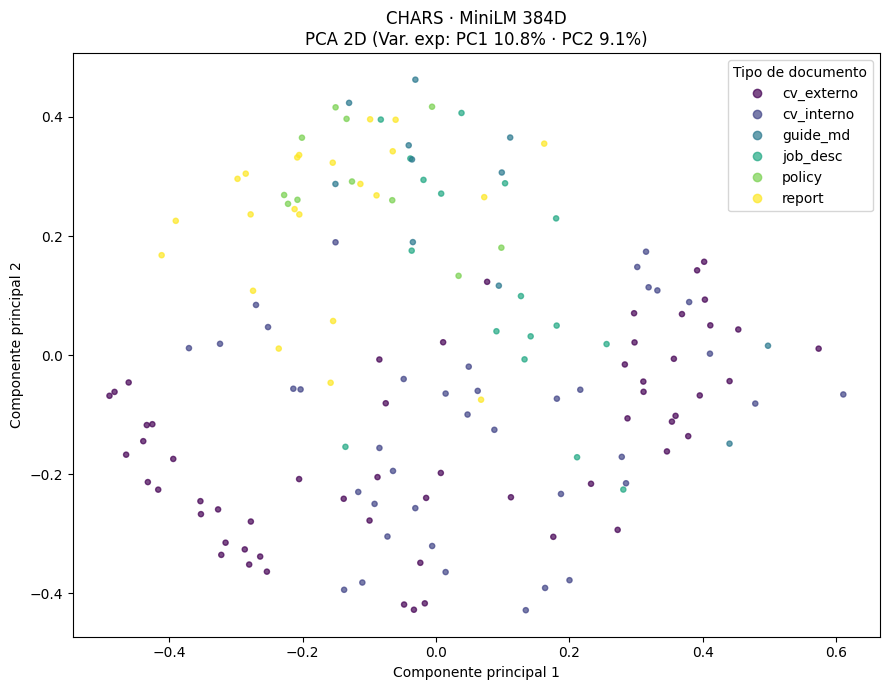

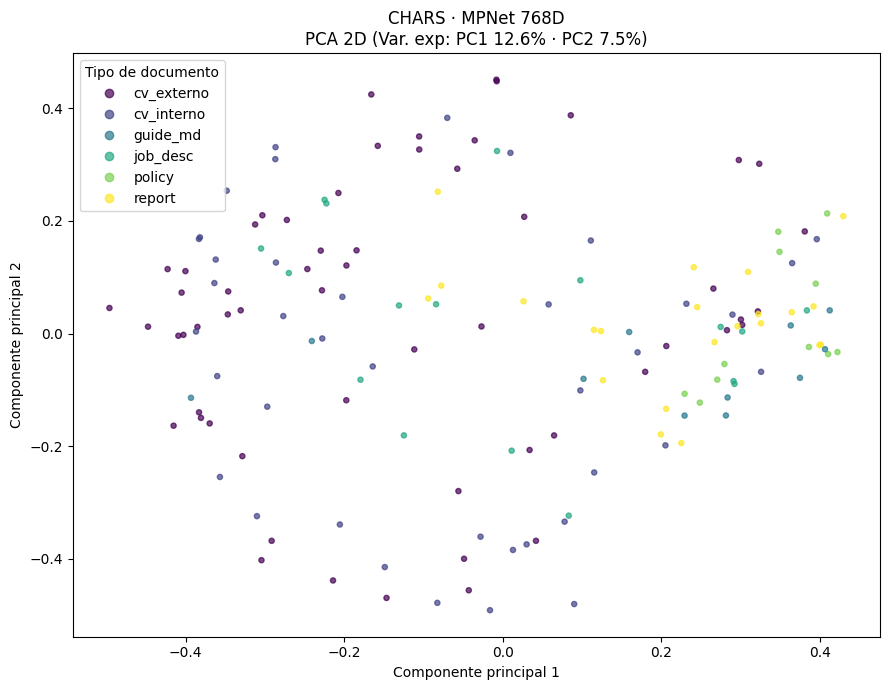

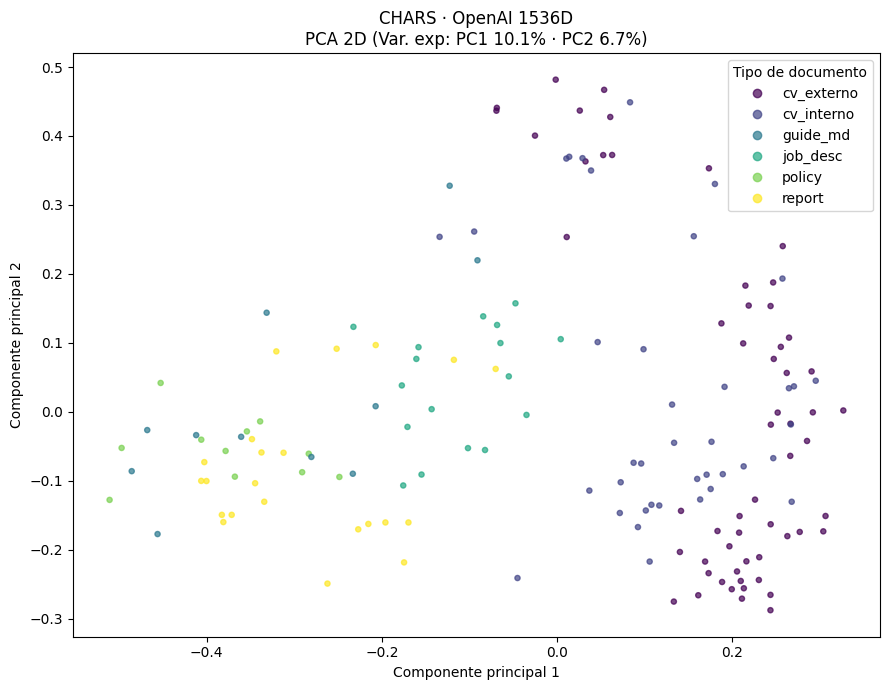

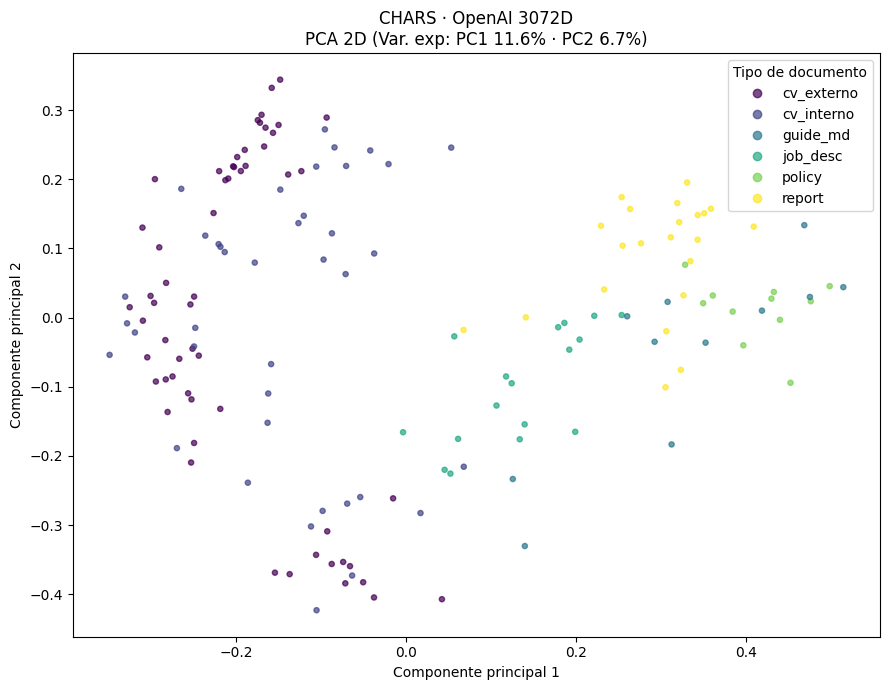

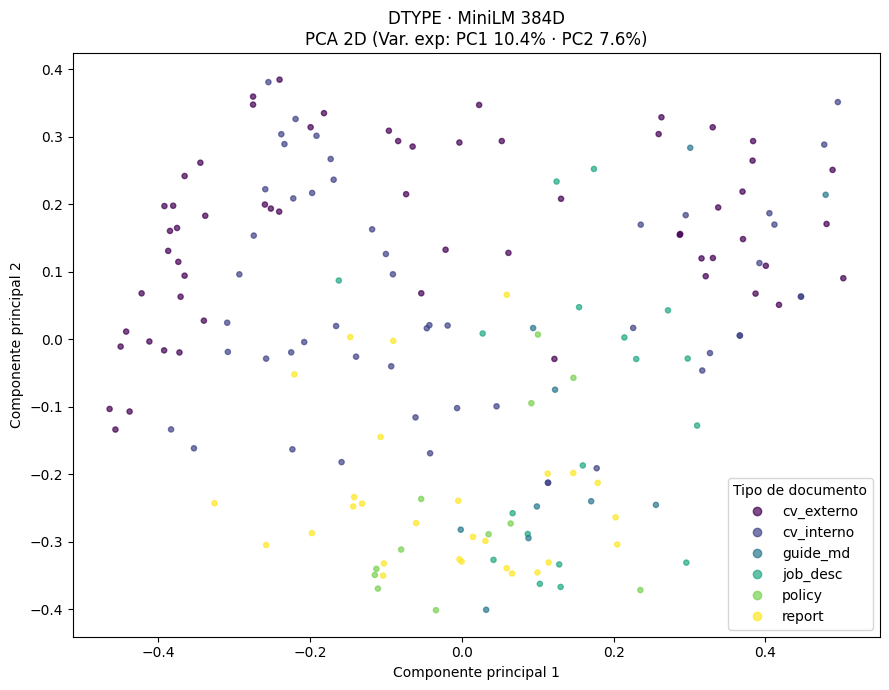

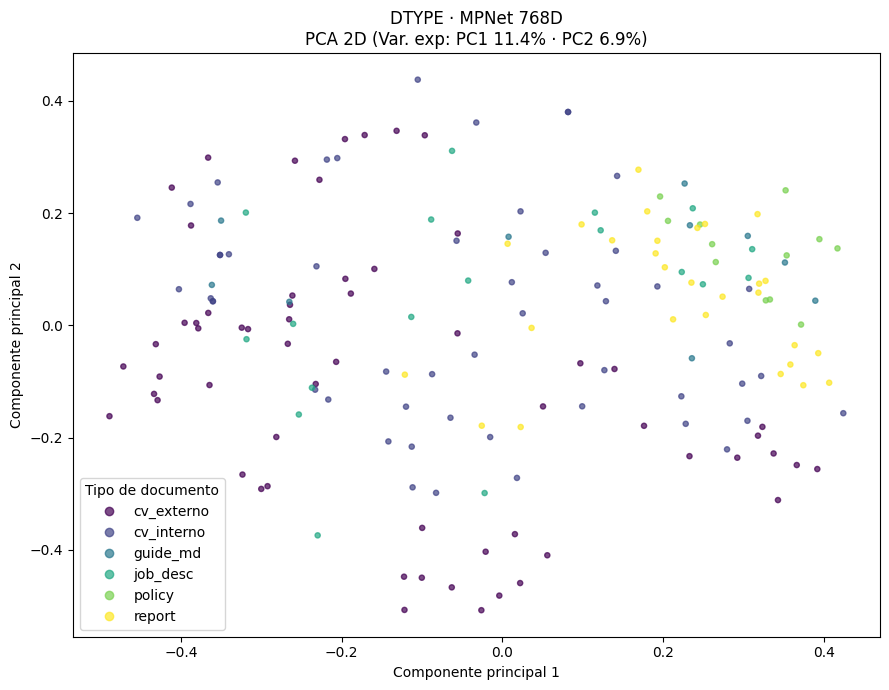

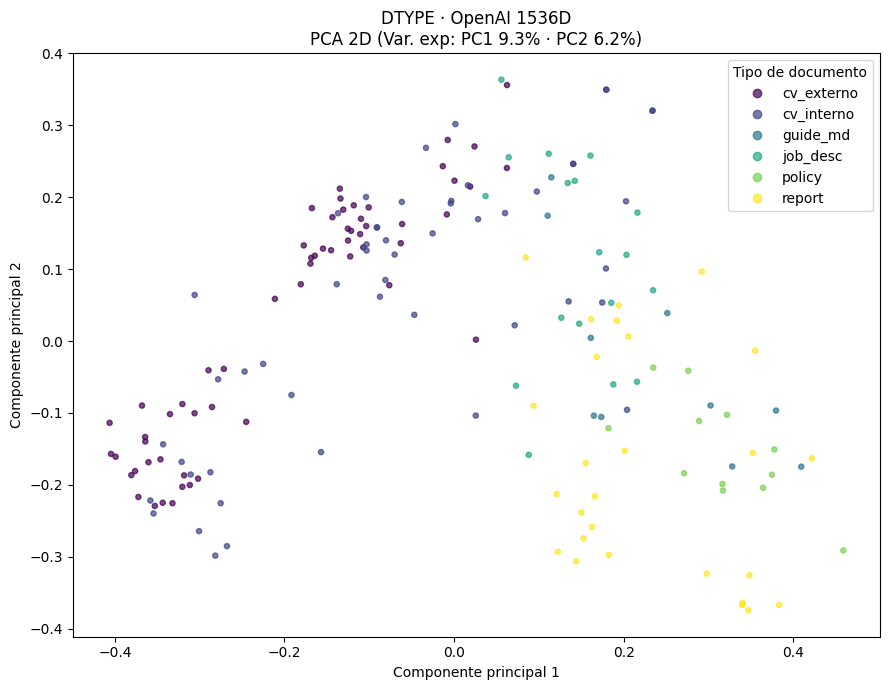

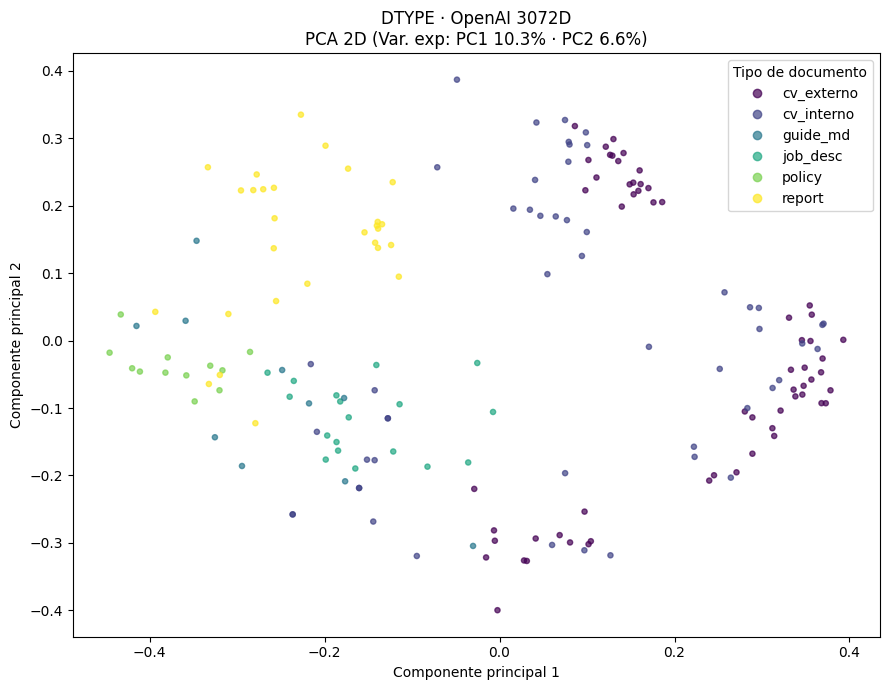

In [13]:
#===============================================================================
# Visualizaci√≥n de embeddings con PCA (por espacio y modelo)
#   - Espacios: CHARS, DTYPE
#   - Modelos: MiniLM 384D, MPNet 768D, OpenAI 1536D, OpenAI 3072D
#===============================================================================
def plot_pca_for_df(df, emb_col: str, title: str, sample_max: int = None):
    """
    Dibuja PCA 2D para un DataFrame y una columna de embeddings concreta.
    - df: DataFrame con columnas ['doc_type', emb_col]
    - emb_col: nombre de la columna que contiene np.ndarray por fila
    - title: t√≠tulo del gr√°fico
    - sample_max: si se indica, hace un muestreo aleatorio de hasta sample_max filas
    """
    if emb_col not in df.columns or len(df) == 0:
        print(f"[Aviso] Columna {emb_col} no encontrada o DF vac√≠o -> {title}")
        return

    data = df[[emb_col, "doc_type"]].copy()

    # Muestreo opcional para evitar saturar el scatter (descomenta si lo necesitas)
    if sample_max is not None and len(data) > sample_max:
        data = data.sample(n=sample_max, random_state=42)

    X = np.vstack(data[emb_col].values).astype(np.float32, copy=False)

    # PCA a 2D
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    # Colores por doc_type
    doc_types = data["doc_type"].astype("category")
    color_codes = doc_types.cat.codes

    plt.figure(figsize=(9, 7))
    scatter = plt.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=color_codes,
        alpha=0.7,
        s=14
    )

    # Leyenda con categor√≠as originales
    handles, _ = scatter.legend_elements()
    legend_labels = list(doc_types.cat.categories)
    plt.legend(handles=handles, labels=legend_labels, title="Tipo de documento", loc="best")

    var_exp = pca.explained_variance_ratio_
    plt.title(f"{title}\nPCA 2D (Var. exp: PC1 {var_exp[0]:.1%} ¬∑ PC2 {var_exp[1]:.1%})")
    plt.xlabel("Componente principal 1")
    plt.ylabel("Componente principal 2")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Espacios y columnas a graficar
# -----------------------------
SPACES = {
    "CHARS": chunks_df_chars,
    "DTYPE": chunks_df_dtype,
}

EMB_COLS = {
    "MiniLM 384D": "emb_384_minilm",
    "MPNet 768D":  "emb_768_mpnet",
    "OpenAI 1536D": "emb_1536_oai_small",
    "OpenAI 3072D": "emb_3072_oai_large",
}

# -----------------------------
# Generar todas las figuras
# -----------------------------
for space_name, df in SPACES.items():
    for model_name, col in EMB_COLS.items():
        plot_pca_for_df(
            df,
            emb_col=col,
            title=f"{space_name} ¬∑ {model_name}",
            sample_max=None  # pon, por ejemplo, 800 si hay much√≠simos puntos
        )



**Conclusiones del gr√°fico de embeddings:**

- **Separaci√≥n por tipo de documento**
  - **MiniLM / MPNet (SBERT)**: Muestran cierta separaci√≥n, pero los clusters son **difusos** y se solapan bastante.  
  - **OpenAI (1536D / 3072D)**: Generan **agrupaciones m√°s claras**. Los *CVs externos e internos* forman bloques compactos, y los *reports* y *policies* quedan m√°s aislados, lo cual facilita consultas espec√≠ficas.  

- **Diferencias entre m√©todos de chunking**
  - **Chars**: Produce cortes mec√°nicos, por lo que los embeddings aparecen **m√°s dispersos**.  
  - **Doctype**: Al segmentar en funci√≥n del tipo de documento, los clusters son **m√°s definidos** y reflejan mejor la estructura sem√°ntica del corpus.  

- **Varianza explicada**
  - Los dos primeros componentes capturan entre **15 % y 20 % de la varianza**.  
  - Aunque es un valor t√≠pico en embeddings de alta dimensi√≥n, lo relevante es que **OpenAI logra una organizaci√≥n m√°s coherente**.  

La combinaci√≥n **Doctype + OpenAI (1536D o 3072D)** parece la m√°s prometedora para el RAG, ya que cuenta con una segmentaci√≥n m√°s sem√°ntica y embeddings con mayor poder discriminativo. A√∫n y as√≠, los embeddings SBERT (MiniLM/MPNet) siguen siendo √∫tiles como **baseline ligero y eficiente** en caso de querer reducir costes y tiempos.  


## 3.4 Evaluaci√≥n del RAG b√°sico

En este bloque vamos a evaluar la **calidad de la recuperaci√≥n sem√°ntica** del sistema RAG. El objetivo es determinar qu√© combinaci√≥n de **estrategia de segmentaci√≥n (chunking)** y **modelo de embeddings** ofrece el mejor equilibrio entre precisi√≥n y coherencia sem√°ntica al recuperar fragmentos relevantes ante consultas reales de RRHH.

**Objetivos de la evaluaci√≥n**:

1. **Medir el rendimiento cuantitativo** del sistema con las distintas configuraciones:
   - **Espacios (space)**:  
     - `chars`: segmentaci√≥n por n√∫mero de caracteres (baseline).  
     - `dtype`: segmentaci√≥n por tipo de documento (sem√°ntica).
   - **Modelos de embeddings (model)**:  
     - `all-MiniLM-L6-v2` (384D)  
     - `all-mpnet-base-v2` (768D)  
     - `text-embedding-3-small` (1536D, OpenAI)  
     - `text-embedding-3-large` (3072D, OpenAI)

2. **Evaluar la precisi√≥n y la calidad de ordenaci√≥n** de los resultados mediante tres m√©tricas:

   - **Hit@K**: Porcentaje de consultas en las que se recupera al menos un documento relevante dentro del top-K.  
   - **MRR (Mean Reciprocal Rank)**: Evaluaci√≥n de la posici√≥n del primer resultado correcto.  
   - **nDCG@K (Normalized Discounted Cumulative Gain)**: Medici√≥n de la calidad global de la ordenaci√≥n de los K resultados. Est√° normalizada en [0, 1]; cuanto **m√°s alta**, mejor.

3. **Comprobar la cobertura**: Asegurar que todos los tipos de documento del corpus (CVs, pol√≠ticas, informes, gu√≠as, etc.) est√°n siendo representados entre los resultados recuperados.

**Ejecuci√≥n**:

1. Cada **consulta de evaluaci√≥n** se transformar√° en un vector de embedding con los distintos modelos.  
2. Se realizar√° una **b√∫squeda sem√°ntica** sobre los √≠ndices FAISS correspondientes (`chars` y `dtype`).  
3. Se calcular√° para cada combinaci√≥n el rendimiento medio en t√©rminos de Hit@K, MRR y nDCG@K.  
4. Se generar√° una **tabla resumen comparativa** para identificar la configuraci√≥n m√°s eficaz.

As√≠ pues, vamos a cuantificar la eficacia del sistema de recuperaci√≥n antes de integrarlo con el modelo generativo (fase de respuesta contextual del RAG).


In [14]:
#===============================================================================
# Dataset de evaluaci√≥n
#===============================================================================

# Normalizador b√°sico
def _norm(s):
    return re.sub(r"\s+", " ", s.lower().strip()) if isinstance(s, str) else ""

# Dataset de evaluaci√≥n ampliado
eval_data = [
    # -----------------------------
    # Candidatos externos (CVs)
    # -----------------------------
    {
        "qid": 0,
        "query": "¬øQu√© candidato externo encajar√≠a mejor para un puesto de analista de datos?",
        "must_keywords": ["analista", "datos"],
        "expected": ["cv_externo"]
    },
    {
        "qid": 1,
        "query": "Mu√©strame perfiles con experiencia en Python y SQL en candidatos externos.",
        "must_keywords": ["python", "sql"],
        "expected": ["cv_externo"]
    },
    # -----------------------------
    # Empleados internos (CVs)
    # -----------------------------
    {
        "qid": 2,
        "query": "¬øQu√© empleados internos tienen experiencia en liderazgo o gesti√≥n de equipos?",
        "must_keywords": ["liderazgo", "equipo"],
        "expected": ["cv_interno"]
    },
    {
        "qid": 3,
        "query": "Encuentra empleados con formaci√≥n en inteligencia artificial o machine learning.",
        "must_keywords": ["inteligencia artificial", "machine learning"],
        "expected": ["cv_interno"]
    },
    # -----------------------------
    # Descripciones de puesto
    # -----------------------------
    {
        "qid": 4,
        "query": "¬øCu√°les son los requisitos de la oferta de desarrollador backend?",
        "must_keywords": ["requisitos", "backend"],
        "expected": ["job_desc"]
    },
    {
        "qid": 5,
        "query": "¬øQu√© beneficios ofrece la empresa en las ofertas de empleo actuales?",
        "must_keywords": ["beneficios", "empleo"],
        "expected": ["job_desc"]
    },
    # -----------------------------
    # Pol√≠ticas internas
    # -----------------------------
    {
        "qid": 6,
        "query": "¬øCu√°l es la pol√≠tica de vacaciones y permisos de la empresa?",
        "must_keywords": ["vacaciones", "permisos"],
        "expected": ["policy"]
    },
    {
        "qid": 7,
        "query": "¬øQu√© normativa regula el teletrabajo y la igualdad en BCN Tech Solutions?",
        "must_keywords": ["teletrabajo", "igualdad"],
        "expected": ["policy"]
    },
    # -----------------------------
    # Informes de rendimiento
    # -----------------------------
    {
        "qid": 8,
        "query": "¬øQu√© conclusiones se extrajeron en los √∫ltimos informes de desempe√±o?",
        "must_keywords": ["conclusiones", "desempe√±o"],
        "expected": ["report"]
    },
    {
        "qid": 9,
        "query": "¬øQu√© recomendaciones se hacen a los empleados con bajo rendimiento?",
        "must_keywords": ["recomendaciones", "rendimiento"],
        "expected": ["report"]
    },
    # -----------------------------
    # Gu√≠as internas
    # -----------------------------
    {
        "qid": 10,
        "query": "¬øD√≥nde se explican los pasos para realizar una evaluaci√≥n de desempe√±o?",
        "must_keywords": ["evaluaci√≥n", "desempe√±o"],
        "expected": ["guide_md"]
    },
    {
        "qid": 11,
        "query": "¬øExiste una gu√≠a interna sobre procedimientos de onboarding?",
        "must_keywords": ["onboarding", "procedimiento"],
        "expected": ["guide_md"]
    },
]

print(f"Total de consultas de evaluaci√≥n: {len(eval_data)}")
pd.DataFrame(eval_data)[["qid","query","expected"]]


Total de consultas de evaluaci√≥n: 12


qid                                              query      expected
0     0  ¬øQu√© candidato externo encajar√≠a mejor para un...  [cv_externo]
1     1  Mu√©strame perfiles con experiencia en Python y...  [cv_externo]
2     2  ¬øQu√© empleados internos tienen experiencia en ...  [cv_interno]
3     3  Encuentra empleados con formaci√≥n en inteligen...  [cv_interno]
4     4  ¬øCu√°les son los requisitos de la oferta de des...    [job_desc]
5     5  ¬øQu√© beneficios ofrece la empresa en las ofert...    [job_desc]
6     6  ¬øCu√°l es la pol√≠tica de vacaciones y permisos ...      [policy]
7     7  ¬øQu√© normativa regula el teletrabajo y la igua...      [policy]
8     8  ¬øQu√© conclusiones se extrajeron en los √∫ltimos...      [report]
9     9  ¬øQu√© recomendaciones se hacen a los empleados ...      [report]
10   10  ¬øD√≥nde se explican los pasos para realizar una...    [guide_md]
11   11  ¬øExiste una gu√≠a interna sobre procedimientos ...    [guide_md]

In [15]:
#===============================================================================
# Evaluaci√≥n del sistema RAG
#===============================================================================

# -----------------------------
# Funci√≥n de b√∫squeda top-K en FAISS
# -----------------------------
def search_topk(query, space, model, k=6):
    """Busca los k chunks m√°s similares a la query en el √≠ndice seleccionado."""
    key = f"{space}_{model}"
    if key not in indices:
        raise ValueError(f"√çndice no encontrado: {key}")

    # Embedding de la consulta seg√∫n el modelo
    if model.startswith("oai"):
        from openai import OpenAI
        client = OpenAI(api_key=api_key)
        emb_model = "text-embedding-3-large" if "3072" in model else "text-embedding-3-small"
        emb = np.array(client.embeddings.create(input=query, model=emb_model).data[0].embedding, dtype=np.float32)
    else:
        embedder = {
            "minilm384": embedder_minilm,
            "mpnet768": embedder_mpnet
        }[model]
        emb = embedder.encode([query], normalize_embeddings=True)[0].astype(np.float32)

    # Consulta FAISS
    index = indices[key]
    emb = emb.reshape(1, -1)
    D, I = index.search(emb, k)
    res = meta[space].iloc[I[0]].copy()
    res["score"] = D[0]
    res["space"] = space
    res["model"] = model
    res["rank"] = np.arange(1, len(res)+1)
    return res

# -----------------------------
# Funciones m√©tricas
# -----------------------------
def hit_at_k(relevant, retrieved):
    return int(any(r in relevant for r in retrieved))

def mrr(relevant, retrieved):
    for i, r in enumerate(retrieved, start=1):
        if r in relevant:
            return 1.0 / i
    return 0.0

def ndcg_at_k(relevant, retrieved, k):
    y_true = [1 if r in relevant else 0 for r in retrieved]
    y_score = list(range(len(retrieved), 0, -1))
    return ndcg_score([y_true], [y_score], k=k)

#============================================================
# Evaluaci√≥n global
#============================================================
def evaluate(eval_data, spaces=("chars","dtype"),
             models=("minilm384","mpnet768","oai1536","oai3072"), k=6):

    results = []
    coverage = {d["expected"][0]: 0 for d in eval_data}

    for qd in eval_data:
        q = qd["query"]
        expected = qd["expected"]
        for space in spaces:
            for model in models:
                rows = search_topk(q, space, model, k=k)
                retrieved = rows["doc_type"].tolist()

                results.append({
                    "query": q,
                    "space": space,
                    "model": model,
                    "hit@k": hit_at_k(expected, retrieved),
                    "MRR": mrr(expected, retrieved),
                    "nDCG@k": ndcg_at_k(expected, retrieved, k),
                })
                for e in expected:
                    coverage[e] = coverage.get(e, 0) + (e in retrieved)

    print("Cobertura por doc_type esperado:", coverage)
    df = pd.DataFrame(results)
    agg = df.groupby(["space","model"], as_index=False)[["hit@k","MRR","nDCG@k"]].mean()
    agg["k"] = k
    agg["n_queries"] = len(eval_data)
    cols = ["space","model","k","n_queries","hit@k","MRR","nDCG@k"]
    return agg[cols].sort_values(by=["space","nDCG@k"], ascending=[True, False]).reset_index(drop=True)


In [16]:
#===============================================================================
# Ejecutar evaluaci√≥n
#===============================================================================
eval_results = evaluate(
    eval_data,
    spaces=("chars","dtype"),
    models=("minilm384","mpnet768","oai1536","oai3072"),
    k=6
)

display(eval_results)

Cobertura por doc_type esperado: {'cv_externo': 13, 'cv_interno': 11, 'job_desc': 11, 'policy': 16, 'report': 16, 'guide_md': 15}


space      model  k  n_queries     hit@k       MRR    nDCG@k
0  chars    oai3072  6         12  1.000000  0.652778  0.762572
1  chars    oai1536  6         12  0.916667  0.563889  0.647594
2  chars   mpnet768  6         12  0.916667  0.537500  0.617436
3  chars  minilm384  6         12  0.750000  0.513889  0.570123
4  dtype    oai3072  6         12  1.000000  0.575000  0.695343
5  dtype    oai1536  6         12  0.833333  0.479167  0.586207
6  dtype   mpnet768  6         12  0.750000  0.430556  0.517750
7  dtype  minilm384  6         12  0.666667  0.377778  0.474440

In [17]:
#===============================================================================
# Ordenar y mostrar los resultados de mejor a peor
#===============================================================================

# Ordenamos por nDCG@k (de mayor a menor)
sorted_results = eval_results.sort_values(by="nDCG@k", ascending=False)

print("Resultados ordenados por nDCG@k (mejor a peor)")
print(sorted_results.to_string(index=False))

Resultados ordenados por nDCG@k (mejor a peor)
space     model  k  n_queries    hit@k      MRR   nDCG@k
chars   oai3072  6         12 1.000000 0.652778 0.762572
dtype   oai3072  6         12 1.000000 0.575000 0.695343
chars   oai1536  6         12 0.916667 0.563889 0.647594
chars  mpnet768  6         12 0.916667 0.537500 0.617436
dtype   oai1536  6         12 0.833333 0.479167 0.586207
chars minilm384  6         12 0.750000 0.513889 0.570123
dtype  mpnet768  6         12 0.750000 0.430556 0.517750
dtype minilm384  6         12 0.666667 0.377778 0.474440


**Resultados de la evaluaci√≥n**:
1. **Modelos de OpenAI**  
   - `oai3072` (OpenAI Large) logra el **mejor rendimiento**: `Hit@K = 1.0` y los nDCG@K m√°s altos en ambos espacios (`chars` y `dtype`).  
   - `oai1536` (OpenAI Small) tambi√©n ofrece resultados s√≥lidos, con un equilibrio favorable entre coste y calidad.

2. **Modelos locales (SBERT)**  
   - `mpnet768` y `minilm384` funcionan razonablemente bien, pero quedan por debajo de los modelos de OpenAI, especialmente en nDCG@K y MRR (peor ordenaci√≥n de los relevantes).  
   - Confirmamos que son alternativas v√°lidas cuando se priorizan latencia, coste o ejecuci√≥n offline.

3. **Estrategias de chunking**  
   - `chars` supera a `dtype` en MRR y nDCG@K, probablemente por la **homogeneidad** del tama√±o de los fragmentos, que favorece la ordenaci√≥n.  
   - `dtype` ofrece **segmentaci√≥n m√°s interpretable** por tipo de documento, √∫til para auditor√≠a y control sem√°ntico, con resultados competitivos cuando se combina con embeddings potentes (especialmente `oai3072`).

**Conclusiones**:

A partir de este punto se descartan el resto de modelos y se mantienen √∫nicamente las dos configuraciones m√°s representativas:

- `chars + oai3072`: lidera las m√©tricas cuantitativas y representa la **m√°xima precisi√≥n en recuperaci√≥n**.  
- `dtype + oai3072`: mantiene un rendimiento s√≥lido y una **estructura sem√°ntica m√°s interpretable** por tipo de documento.

En la siguiente fase vamos a evaluar **el impacto real de estas dos configuraciones en la generaci√≥n de respuestas con un modelo LLM**, comparando no solo la recuperaci√≥n, sino tambi√©n la **calidad, coherencia y contextualizaci√≥n** de las respuestas generadas.


# 4. Implementaci√≥n del LLM

## 4.1 Evaluaci√≥n de RAG con LLM

En esta fase vamos a integrar un modelo de lenguaje (LLM) para evaluar el comportamiento completo del sistema RAG, utilizando los dos enfoques seleccionados en la fase anterior:

- **`chars + oai3072`**: Segmentaci√≥n uniforme por n√∫mero de caracteres.  
- **`dtype + oai3072`**: Segmentaci√≥n adaptada al tipo de documento.

Cada configuraci√≥n se probar√° con tres consultas representativas de RRHH, cubriendo perfiles de candidatos, pol√≠ticas internas y evaluaciones de desempe√±o.

In [18]:
#===============================================================================
# Evaluaci√≥n cualitativa del sistema RAG con LLM
#===============================================================================

# Configuraci√≥n de los modelos RAG a comparar
RAG_CONFIGS = [
    {"space": "chars",  "model": "oai3072", "label": "chars + oai3072"},
    {"space": "dtype",  "model": "oai3072", "label": "dtype + oai3072"}
]

# Par√°metros de recuperaci√≥n
TOP_K = 4  # n√∫mero de chunks que se pasan como contexto al LLM

#------------------------------------------------------------
# Funci√≥n para recuperar contexto con FAISS
#------------------------------------------------------------
def retrieve_context(query, space, model, k=TOP_K):
    """Recupera los k fragmentos m√°s relevantes seg√∫n el √≠ndice FAISS."""
    rows = search_topk(query, space, model, k=k)
    context = "\n\n".join(rows["chunk_text"].tolist())
    return context, rows

#------------------------------------------------------------
# Funci√≥n de generaci√≥n con LLM
#------------------------------------------------------------
def generate_answer(query, context, model="gpt-4o-mini"):
    """Genera una respuesta del LLM usando el contexto proporcionado."""
    prompt = f"""
    Eres un asistente de recursos humanos de la empresa BCN Tech Solutions.
    Usa √∫nicamente la informaci√≥n del siguiente contexto para responder la pregunta del usuario.

    CONTEXTO:
    {context}

    PREGUNTA:
    {query}

    RESPUESTA (concisa, formal y basada en el contexto):
    """
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=350
    )
    return response.choices[0].message.content.strip()

#------------------------------------------------------------
# Ejecuci√≥n del experimento cualitativo
#------------------------------------------------------------
results = []
sample_queries = [
    "¬øQu√© candidato externo encajar√≠a mejor para un puesto de analista de datos? Menciona su nombre.",
    "¬øCu√°l es la pol√≠tica de vacaciones y permisos de la empresa?",
    "¬øQu√© conclusiones se extrajeron en los √∫ltimos informes de desempe√±o? Menciona el nombre del mejor empleado.",
]

for cfg in RAG_CONFIGS:
    print(f"\n Generando respuestas con {cfg['label']}")
    for q in sample_queries:
        context, retrieved = retrieve_context(q, cfg["space"], cfg["model"], k=TOP_K)
        answer = generate_answer(q, context)
        results.append({
            "config": cfg["label"],
            "query": q,
            "answer": answer,
            "context_preview": context[:400] + "..."  # solo mostramos parte del contexto
        })

# Convertimos a DataFrame para inspecci√≥n
df_llm_eval = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
display(df_llm_eval[["config", "query", "answer"]])



 Generando respuestas con chars + oai3072

 Generando respuestas con dtype + oai3072


config  \
0  chars + oai3072   
1  chars + oai3072   
2  chars + oai3072   
3  dtype + oai3072   
4  dtype + oai3072   
5  dtype + oai3072   

                                                                                                          query  \
0               ¬øQu√© candidato externo encajar√≠a mejor para un puesto de analista de datos? Menciona su nombre.   
1                                                  ¬øCu√°l es la pol√≠tica de vacaciones y permisos de la empresa?   
2  ¬øQu√© conclusiones se extrajeron en los √∫ltimos informes de desempe√±o? Menciona el nombre del mejor empleado.   
3               ¬øQu√© candidato externo encajar√≠a mejor para un puesto de analista de datos? Menciona su nombre.   
4                                                  ¬øCu√°l es la pol√≠tica de vacaciones y permisos de la empresa?   
5  ¬øQu√© conclusiones se extrajeron en los √∫ltimos informes de desempe√±o? Menciona el nombre del mejor empleado.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            answer  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             El candidato externo que encajar√≠a mejor para un puesto de analista de datos es Ciro Esteban Belda Nadal, quien cuenta con experiencia previa en pr√°cticas en el sector tecnol√≥gico.  
1                                                                                              La pol√≠tica de vacaciones de BCN Tech Solutions establece que todos los empleados disponen de 23 d√≠as laborables de vacaciones al a√±o, los cuales pueden ser distribuidos de forma flexible en coordinaci√≥n con el equipo. Las solicitudes de vacaciones deben realizarse con al menos 2 semanas de antelaci√≥n.\n\nEn cuanto a la pol√≠tica de permisos y ausencias, los empleados tienen derecho a permisos retribuidos por motivos personales, como matrimonio, nacimiento de hijo o fallecimiento de familiar, as√≠ como a licencias sin sueldo por causas justificadas. Las ausencias deben ser notificadas lo antes posible al manager directo y al equipo de RRHH, y se requiere justificar documentalmente los permisos especiales en los plazos establecidos.  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Los √∫ltimos

**Resultados de la evaluaci√≥n cualitativa**  

Como podemos observar, el modelo **`chars + oai3072`** ofrece un **mayor aprovechamiento del contexto** y genera respuestas **m√°s completas, precisas y espec√≠ficas**, siendo capaz incluso de identificar nombres concretos de empleados o candidatos en las respuestas.  

Por el contrario, el modelo **`dtype + oai3072`** presenta un **alcance contextual m√°s limitado**. En varios casos, el LLM no logra encontrar suficiente informaci√≥n relevante, lo que sugiere que la segmentaci√≥n por tipo de documento restringe parte del contenido √∫til que llega al modelo generativo.  

- **`chars + oai3072`** demuestra una **mayor densidad sem√°ntica** y una **recuperaci√≥n de contexto m√°s efectiva**.  
- **`dtype + oai3072`** mantiene una buena coherencia estructural, pero sacrifica detalle al acotar demasiado las fuentes de informaci√≥n.  

**Conclusi√≥n final:**  
El **modelo `chars + oai3072`**, ofrece la **mejor cobertura, precisi√≥n contextual y calidad general de las respuestas**. Por lo que vamos a construir nuestro **RAG final** con **este modelo**.


# 5. Asistente RAG con LLM

**Interfaz interactiva**

En esta √∫ltima secci√≥n del proyecto se integra todo el sistema completo del **asistente RAG de Recursos Humanos**.  
El objetivo es permitir que el usuario formule una **pregunta libre** y que el sistema:

1. **Genere el embedding de la consulta** utilizando el modelo `text-embedding-3-large` (OpenAI, 3072 dimensiones).  
2. **Busque los fragmentos m√°s relevantes** dentro del corpus indexado mediante **FAISS**, utilizando el espacio seleccionado (`chars + oai3072`).  
3. **Visualice gr√°ficamente la consulta** en un mapa 2D (reducci√≥n PCA), donde se muestra su posici√≥n relativa respecto a todos los documentos seg√∫n su tipo (`CVs`, `pol√≠ticas`, `informes`, etc.).  
4. **Genere una respuesta final con el modelo LLM (`gpt-4o-mini`)**, utilizando el contexto recuperado y siguiendo un estilo formal y conciso propio de un asistente de RRHH.

Esta celda representa el **flujo completo del sistema RAG con LLM integrado**, desde la entrada del usuario hasta la generaci√≥n final de la respuesta, ofreciendo adem√°s una representaci√≥n visual del **razonamiento sem√°ntico** del modelo.

Introduce tu pregunta para el asistente de RRHH: ¬øQu√© pasos debo seguir para solicitar una revisi√≥n salarial?


/tmp/ipython-input-4292331768.py:50: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 7
  plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels + ["Consulta"], title="Tipo de documento", loc="best")


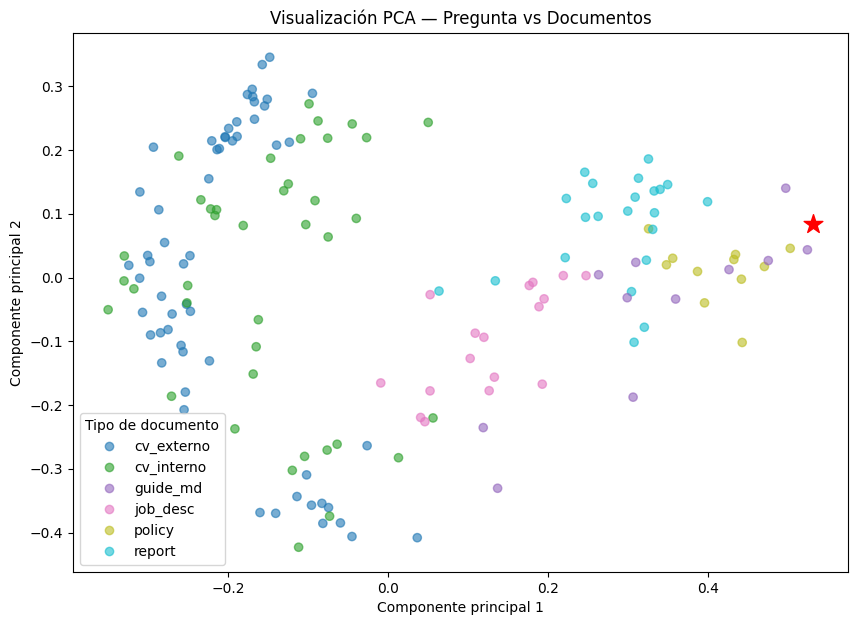

Pregunta del usuario:
¬øQu√© pasos debo seguir para solicitar una revisi√≥n salarial?

Contexto recuperado (resumen):
Proceso para Solicitar una Revisi√≥n Salarial

¬øQui√©n puede solicitarla?

Cualquier empleado con al menos 12 meses de antig√ºedad o tras una evoluci√≥n significativa de responsabilidades.

Pasos a seguir

Redacta un documento explicando los mo



Redacta un documento explicando los motivos de la solicitud.

Adjunta evidencias de tu evoluci√≥n y rendimiento.

Env√≠a el documento a tu manager directo y a RRHH.

RRHH evaluar√° junto al √°rea financiera la viabilidad.

Criterios comunes



zadas

¬øC√≥mo aplicar?

Haz clic en la vacante que te interesa

Revisa los requisitos y funciones

Adjunta tu CV actu...

Respuesta del asistente:
Para solicitar una revisi√≥n salarial, debes seguir los siguientes pasos:

1. Redacta un documento explicando los motivos de tu solicitud.
2. Adjunta evidencias de tu evoluci√≥n y rendimiento.
3. Env√≠a el documento a tu manager directo y a 

In [19]:
#===============================================================================
# Interfaz interactiva ‚Äî Pregunta libre con visualizaci√≥n y respuesta RAG
#===============================================================================

#------------------------------------------------------------
# Par√°metros del modelo final
#------------------------------------------------------------
FINAL_SPACE = "chars"
FINAL_MODEL = "oai3072"
TOP_K = 4
LLM_MODEL = "gpt-4o-mini"

#------------------------------------------------------------
# Funci√≥n de visualizaci√≥n PCA
#------------------------------------------------------------
def visualizar_consulta(query_vector, df, emb_col="emb_3072_oai_large", title="Visualizaci√≥n PCA ‚Äî Pregunta vs Documentos"):
    """
    Muestra una visualizaci√≥n PCA con todos los embeddings y la pregunta del usuario destacada.
    """
    # Extraemos los embeddings existentes
    X = np.vstack(df[emb_col].values)
    doc_types = df["doc_type"].astype("category")

    # Unimos el embedding de la pregunta para proyectarlo en el mismo espacio
    X_full = np.vstack([X, query_vector])

    # PCA a 2D
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_full)

    # √öltimo punto corresponde a la pregunta
    query_point = X_2d[-1]
    X_docs = X_2d[:-1]

    # Visualizaci√≥n
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        X_docs[:, 0], X_docs[:, 1],
        c=doc_types.cat.codes,
        cmap="tab10",
        alpha=0.6,
        label=None
    )

    # Punto de la consulta en rojo
    plt.scatter(query_point[0], query_point[1], c="red", s=200, marker="*", label="Consulta")

    # Leyenda
    legend_labels = list(doc_types.cat.categories)
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels + ["Consulta"], title="Tipo de documento", loc="best")
    plt.title(title)
    plt.xlabel("Componente principal 1")
    plt.ylabel("Componente principal 2")
    plt.show()

#------------------------------------------------------------
# Flujo principal interactivo
#------------------------------------------------------------
# Entrada del usuario
user_query = input("Introduce tu pregunta para el asistente de RRHH: ")

# Embedding de la consulta con el modelo OpenAI
query_embedding = client.embeddings.create(
    model="text-embedding-3-large",
    input=user_query
).data[0].embedding
query_embedding = np.array(query_embedding, dtype=np.float32).reshape(1, -1)

# Recuperamos el contexto con FAISS
context, retrieved = retrieve_context(user_query, FINAL_SPACE, FINAL_MODEL, k=TOP_K)

# Visualizamos la posici√≥n de la consulta frente a los documentos
visualizar_consulta(query_embedding, chunks_df_chars, emb_col="emb_3072_oai_large")

# Generamos la respuesta final del LLM con el contexto recuperado
final_answer = generate_answer(user_query, context, model=LLM_MODEL)

# Mostramos resultados
print("Pregunta del usuario:")
print(user_query)
print("\nContexto recuperado (resumen):")
print(context[:600] + "...")
print("\nRespuesta del asistente:")
print(final_answer)

# 6. Conclusiones

Valor aportado a RRHH con este sistema

Limitaciones del sistema actual

Qu√© podr√≠a mejorarse en una futura versi√≥n

¬øQu√© documentos y formatos has utilizado?

¬øC√≥mo has dividido y preparado los datos para el sistema?

¬øQu√© modelo y vector DB has usado y por qu√©?

¬øC√≥mo eval√∫as la calidad de las respuestas?

¬øCu√°l fue tu propuesta de mejora y cu√°l fue su impacto?

¬øQu√© aprendiste sobre los sistemas RAG y sus limitaciones?


**RESPONDER CON TEXTO ESTRUCTURADO, NO Q&A!!!**

**Conclusiones finales del proyecto: Asistente RAG para RRHH**

El desarrollo de este sistema RAG aplicado al √°rea de Recursos Humanos ha permitido demostrar c√≥mo la inteligencia artificial puede mejorar la gesti√≥n documental y la toma de decisiones dentro de una organizaci√≥n. A trav√©s de la combinaci√≥n de recuperaci√≥n sem√°ntica y modelos de lenguaje, el asistente es capaz de responder a preguntas complejas sobre empleados, pol√≠ticas internas o procesos de selecci√≥n con precisi√≥n y respaldo documental. En un entorno real, esta herramienta podr√≠a ahorrar horas de trabajo administrativo, facilitando el acceso inmediato a informaci√≥n relevante y reduciendo los errores humanos derivados de b√∫squedas manuales.

A lo largo del proyecto se utilizaron diferentes tipos de documentos que simulan el ecosistema t√≠pico de un departamento de RRHH: curr√≠culums internos y externos, descripciones de puestos, pol√≠ticas corporativas, informes de rendimiento y gu√≠as en formato markdown. Todos estos archivos, procedentes de distintos formatos como PDF, DOCX y MD, fueron procesados y limpiados para eliminar inconsistencias, unificar saltos de l√≠nea y preservar la estructura sem√°ntica de los textos. Posteriormente, el corpus se dividi√≥ mediante varios m√©todos de *chunking* con el objetivo de equilibrar precisi√≥n y coherencia contextual. Tras varias pruebas, los enfoques `chars` y `doctype` resultaron ser los m√°s adecuados: el primero por su consistencia y el segundo por ofrecer segmentaciones m√°s interpretables.

Para la base vectorial se utiliz√≥ FAISS, para la b√∫squeda por similitud coseno, junto con diversos modelos de embeddings que permitieron comparar rendimiento y profundidad sem√°ntica. Entre ellos, los modelos de OpenAI (`text-embedding-3-small` y `text-embedding-3-large`) destacaron claramente frente a los locales de Sentence Transformers (`MiniLM` y `MPNet`). La combinaci√≥n final seleccionada ‚Äî`chars + oai3072`‚Äî demostr√≥ ofrecer el mejor equilibrio entre precisi√≥n, coherencia y riqueza contextual, permitiendo que el LLM (`gpt-4o-mini`) generara respuestas completas, concisas y bien fundamentadas en los documentos originales.

Para medir la calidad del sistema, se aplic√≥ una evaluaci√≥n tanto cuantitativa como cualitativa. En la primera, m√©tricas como *Hit@K*, *MRR* y *nDCG@K* confirmaron una alta capacidad de recuperaci√≥n de informaci√≥n relevante, especialmente con los embeddings de OpenAI. En la segunda, las respuestas generadas por el LLM mostraron una gran coherencia con las pol√≠ticas internas, perfiles de empleados y conclusiones de desempe√±o. Este proceso de evaluaci√≥n sirvi√≥ no solo para validar la efectividad del sistema, sino tambi√©n para entender c√≥mo distintas configuraciones afectan la calidad final de la respuesta.

El principal valor de este asistente radica en su capacidad de **convertir documentos est√°ticos en conocimiento consultable**, mejorando la accesibilidad de la informaci√≥n y potenciando la toma de decisiones informadas. Sin embargo, el sistema no est√° exento de limitaciones: depende de la calidad y diversidad del corpus, no se actualiza autom√°ticamente y requiere una revisi√≥n humana en casos ambiguos. Adem√°s, los fragmentos de texto pueden cortarse de manera imperfecta si los l√≠mites de chunking no se ajustan adecuadamente al contenido.

Una versi√≥n futura del proyecto podr√≠a incorporar una base de datos vectorial especializada (como Chroma o Milvus) que permita actualizaciones incrementales, junto con un motor h√≠brido de b√∫squeda que combine recuperaci√≥n sem√°ntica y exacta. Tambi√©n ser√≠a interesante a√±adir un front end para acercar mejor el modelo a usuarios no t√©cnicos, as√≠ como un sistema de trazabilidad visual que muestre al usuario de qu√© documentos proviene cada fragmento utilizado por el modelo.

A nivel t√©cnico y conceptual, este trabajo ha sido una excelente oportunidad para profundizar en los principios de los sistemas RAG. El proceso ha puesto en relieve que el rendimiento de este tipo de arquitecturas depende tanto de los modelos como del dise√±o del pipeline: limpieza, segmentaci√≥n, embeddings, indexaci√≥n y postprocesado deben funcionar como un engranaje coherente. En definitiva, este proyecto demuestra que los sistemas RAG no solo son viables en entornos corporativos, sino que representan una evoluci√≥n natural en la manera en que las empresas gestionan, entienden y aprovechan su propio conocimiento interno.


# 7. Anexos

En el desarrollo del TFM **‚ÄúAsistente RAG para el √°rea de Recursos Humanos de BCN Tech Solutions‚Äù**, se han utilizado m√∫ltiples librer√≠as y servicios orientados al procesamiento de documentos, generaci√≥n de embeddings, b√∫squeda sem√°ntica y evaluaci√≥n de un sistema RAG (Retrieval-Augmented Generation).  
A continuaci√≥n, se documentan todas las herramientas empleadas, clasificadas seg√∫n su funci√≥n dentro del proyecto, junto con las referencias oficiales a su documentaci√≥n.

---

**1. Procesamiento y gesti√≥n de archivos**
- **os**: gesti√≥n de rutas y archivos del sistema.  
  [Documentaci√≥n](https://docs.python.org/3/library/os.html)  
- **glob**: b√∫squeda de archivos mediante patrones.  
  [Documentaci√≥n](https://docs.python.org/3/library/glob.html)  
- **re**: expresiones regulares para limpieza y normalizaci√≥n de texto.  
  [Documentaci√≥n](https://docs.python.org/3/library/re.html)  
- **string**: utilidades de manipulaci√≥n de texto.  
  [Documentaci√≥n](https://docs.python.org/3/library/string.html)  
- **time**: medici√≥n de tiempos de ejecuci√≥n.  
  [Documentaci√≥n](https://docs.python.org/3/library/time.html)  
- **collections.defaultdict**: estructuras de datos avanzadas para agrupaci√≥n de informaci√≥n.  
  [Documentaci√≥n](https://docs.python.org/3/library/collections.html#collections.defaultdict)  

---

**2. Manipulaci√≥n y an√°lisis de datos**
- **pandas**: creaci√≥n y gesti√≥n de DataFrames para almacenar corpus y resultados.  
  [Documentaci√≥n](https://pandas.pydata.org/docs/)  
- **numpy**: operaciones vectoriales y num√©ricas, base de todos los c√°lculos con embeddings.  
  [Documentaci√≥n](https://numpy.org/doc/)  

---

**3. Lectura de documentos multiformato**
- **PyMuPDF (fitz)**: extracci√≥n de texto desde archivos PDF.  
  [Documentaci√≥n](https://pymupdf.readthedocs.io/en/latest/)  
- **python-docx**: lectura y an√°lisis de documentos Word (.docx).  
  [Documentaci√≥n](https://python-docx.readthedocs.io/en/latest/)  
- **markdown**: conversi√≥n de archivos Markdown a HTML.  
  [Documentaci√≥n](https://python-markdown.github.io/)  
- **BeautifulSoup (bs4)**: limpieza de HTML y obtenci√≥n del texto plano.  
  [Documentaci√≥n](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)  

---

**4. Procesamiento de lenguaje natural y embeddings**
- **sentence-transformers**: generaci√≥n de embeddings sem√°nticos mediante modelos open-source (MiniLM, MPNet).  
  [Documentaci√≥n](https://www.sbert.net/)  
- **faiss**: creaci√≥n de √≠ndices vectoriales y b√∫squeda por similitud (coseno / producto interno).  
  [Documentaci√≥n](https://github.com/facebookresearch/faiss)  
- **OpenAI API**: generaci√≥n de embeddings avanzados (`text-embedding-3-small`, `text-embedding-3-large`) y respuestas con LLM (`gpt-4o-mini`).  
  [Documentaci√≥n](https://platform.openai.com/docs/)  

---

**5. Reducci√≥n de dimensionalidad y visualizaci√≥n**
- **scikit-learn (sklearn)**:  
  - `PCA`: reducci√≥n de dimensiones para visualizaci√≥n de embeddings.  
  - `TfidfVectorizer`: vectorizaci√≥n de texto tradicional (para an√°lisis previos).  
  - `cosine_similarity` y `ndcg_score`: m√©tricas de evaluaci√≥n de recuperaci√≥n y ranking.  
  [Documentaci√≥n](https://scikit-learn.org/stable/documentation.html)  
- **matplotlib**: creaci√≥n de gr√°ficos 2D para la exploraci√≥n y comparaci√≥n de embeddings.  
  [Documentaci√≥n](https://matplotlib.org/stable/contents.html)  
- **seaborn**: visualizaci√≥n estad√≠stica avanzada basada en matplotlib.  
  [Documentaci√≥n](https://seaborn.pydata.org/)  
- **wordcloud**: generaci√≥n de nubes de palabras para exploraci√≥n inicial del corpus.  
  [Documentaci√≥n](https://amueller.github.io/word_cloud/)  

---

**6. Configuraci√≥n y seguridad**
- **python-dotenv**: carga segura de variables de entorno, como la clave de la API de OpenAI.  
  [Documentaci√≥n](https://pypi.org/project/python-dotenv/)  

---

**7. Integraci√≥n con Google Colab**
- **google.colab.drive**: montaje del sistema de archivos de Google Drive para leer y guardar datos del proyecto.  
  [Referencia](https://colab.research.google.com/notebooks/io.ipynb)  

---

**8. Repositorio del proyecto**
- **GitHub**:  
  Repositorio oficial del proyecto ‚ÄúTFM 2 ‚Äî Asistente RAG para RRHH‚Äù.  
  [Repositorio](https://github.com/davidmartimar/tfm-2-rag-rrhh)

---

**Resumen t√©cnico**  
Este entorno de desarrollo combina herramientas de **procesamiento documental**, **embeddings sem√°nticos** y **b√∫squeda vectorial** para crear un sistema RAG capaz de consultar documentos empresariales heterog√©neos de forma eficiente. El uso conjunto de *Sentence Transformers*, *FAISS* y *OpenAI* permiti√≥ comparar modelos locales y API externas, obteniendo un sistema h√≠brido de recuperaci√≥n y generaci√≥n que simula un asistente de RRHH funcional y evaluable dentro de Google Colab.
